# Importing Libraries

In [5]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import t
from tabulate import tabulate
from IPython.display import display, HTML
import os

# Importing Random Variable Generators

In [2]:
import sys

# Getting the path to Parent Directory
root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..')) if '__file__' in globals() \
               else os.path.abspath(os.path.join(os.getcwd(), '..'))

# Adding it to sys.path so Python can find 'scripts'
if root not in sys.path:
    sys.path.append(root)

# Now we can import our classes
# from scripts.random_utils import Normal, InverseGamma


# Importing Dataset

In [2]:
df = pd.read_csv("../data/processed/trades_2025-10-01_to_2025-10-07_1min.csv")

# Joint Normal Model

In [4]:
class Joint_Normal:
    def __init__(self, mu, k, sigma2, r, lag, df: pd.DataFrame):
        if min(sigma2, k ,r) <= 0:
            raise ValueError("sigma2, k, r must be > 0")
        if lag <=0:
            raise ValueError("lag must be a Natural number")
            
        self.lag = (lag)
        self.df = df
        
        self.params = {"mu":[mu], "k": [k], "sigma2":[sigma2], "r": [r]}
        self.ppi = {}

    def generate_posterior(self):
        df = self.df
        df = df.sort_values(by="timestamp").reset_index(drop=True)
        array = np.log(df["cost"].tolist())

        for i in range(len(array)):
            n = 0
            # sum_volume =0
            # sum2_volume =0
            
            window = array[max(0, i - self.lag):i]
            
            if len(window) < 2:
                continue
                
            n = len(window)

            # sample mean and sample variance calculation
            ybar = np.mean(window)
            s2 = np.var(window, ddof=1)

            # prior parameters
            mu0, k0, sigma20, r0 = self.params["mu"][0], self.params["k"][0], self.params["sigma2"][0], self.params["r"][0]

            # posterior updates
            kn = k0 + n
            rn = r0 + n

            mun = (k0 * mu0 + n * ybar) / kn
            sigma2n = (r0 * sigma20  + (n-1) * s2 + k0 * n * ((ybar - mu0)**2) / kn ) / rn
            
            self.params["mu"].append(mun)
            self.params["k"].append(kn)
            self.params["sigma2"].append(sigma2n)
            self.params["r"].append(rn)
        

    def generate_ppi(self, percent):
        ppis = {"lower_bound": [], "upper_bound": []}
        alpha = 1 - percent
    
        for i in range(1, len(self.params["mu"])):
            mu_n = self.params["mu"][i]
            k_n = self.params["k"][i]
            sigma2_n = self.params["sigma2"][i]
            r_n = self.params["r"][i]
    
            if np.isnan(sigma2_n) or np.isnan(k_n):
                print(f"NaN encountered: sigma2_n={sigma2_n}, k_n={k_n}, i={i}")
            elif sigma2_n < 0:
                print(f"Negative sigma2_n={sigma2_n}, i={i}")
            elif k_n == 0:
                print(f"k_n==0 at i={i}")

            # degrees of freedom for posterior predictive distribution
            df = 2 * r_n  
            # scale for predictive distribution
            scale = (sigma2_n * (1 + 1/k_n)) ** 0.5  
    
            # credible interval bounds using t-distribution
            lower = scipy.stats.t.ppf(alpha / 2, df, loc=mu_n, scale=scale)
            upper = scipy.stats.t.ppf(1 - alpha / 2, df, loc=mu_n, scale=scale)
    
            ppis["lower_bound"].append(lower)
            ppis["upper_bound"].append(upper)
    
        self.ppi[percent] = ppis


# Observed Vs Posterior Mean log Trade Volume $(\log(volumne))$

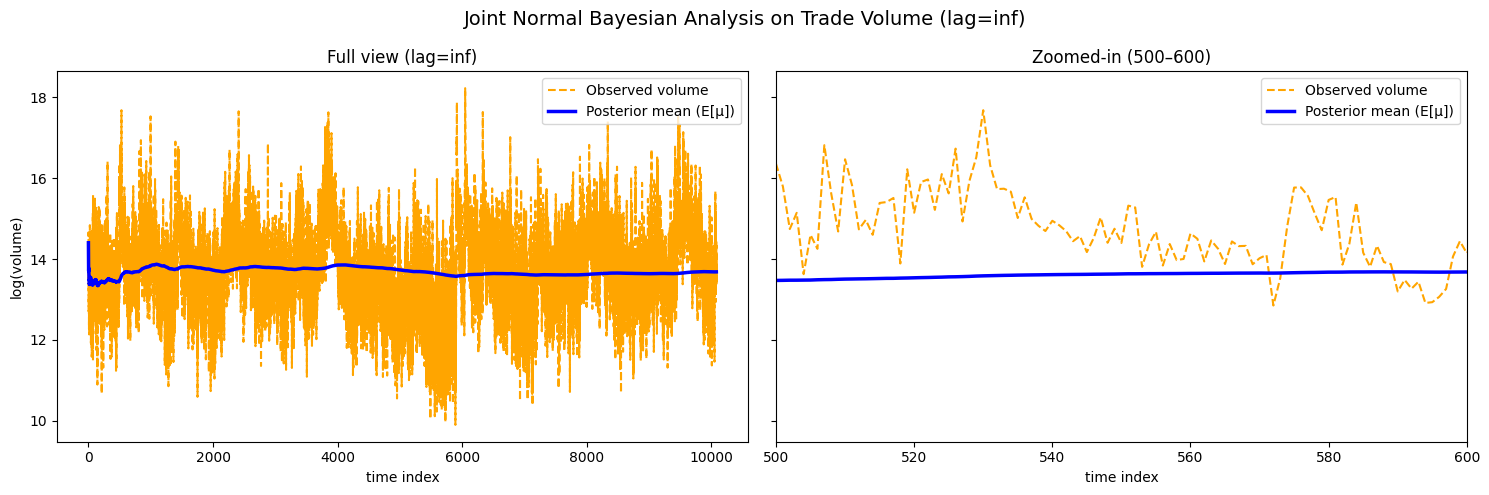

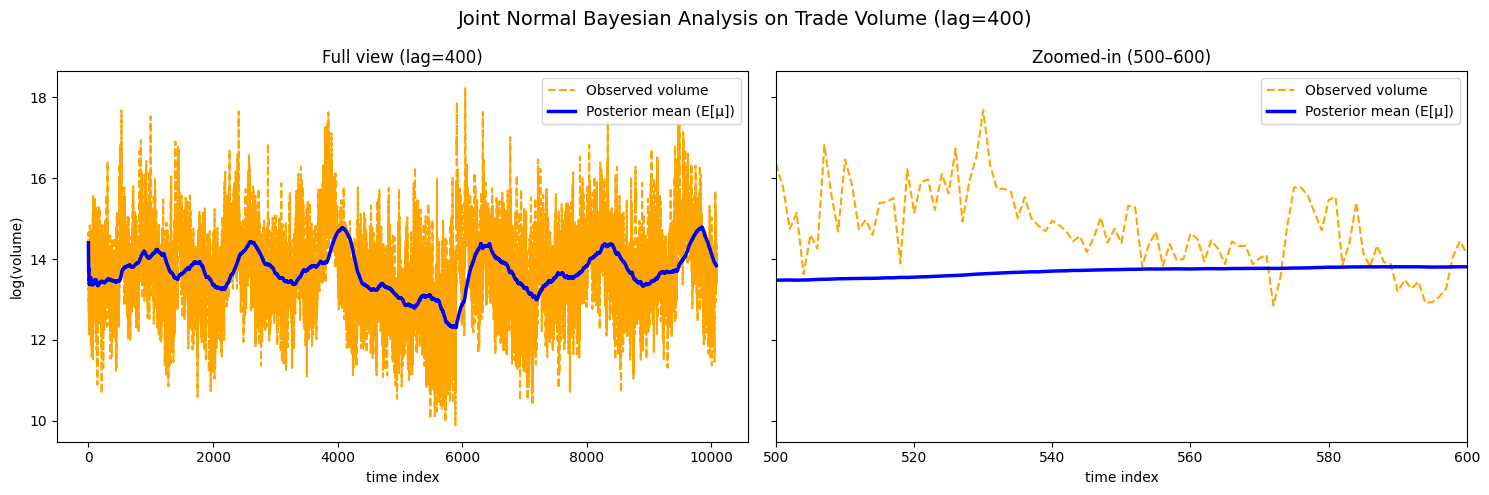

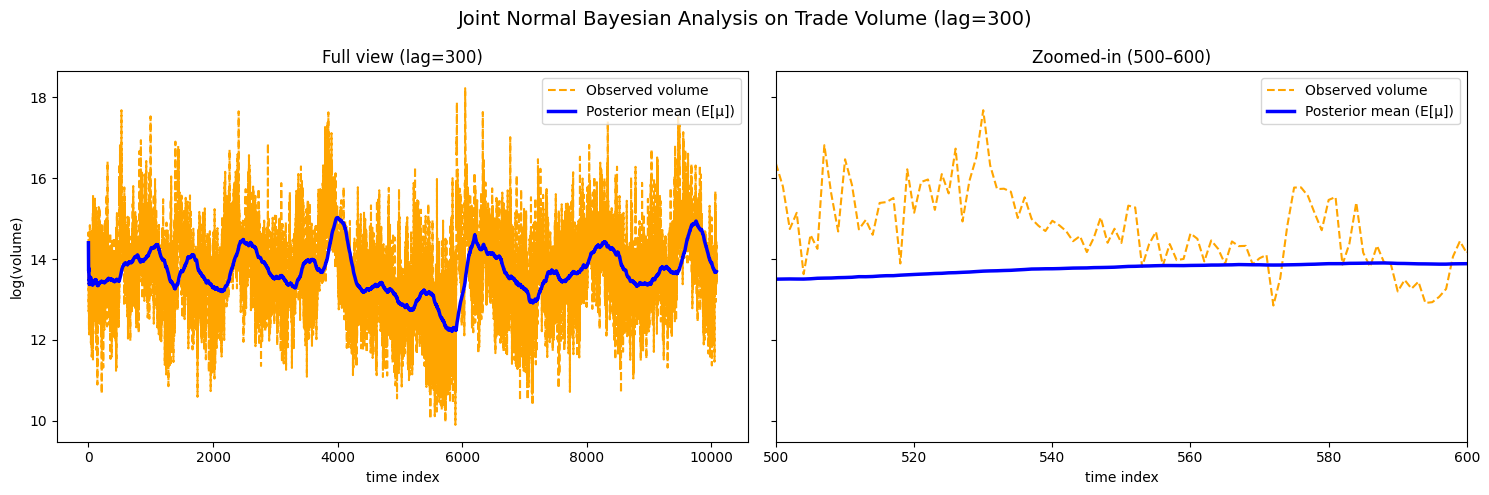

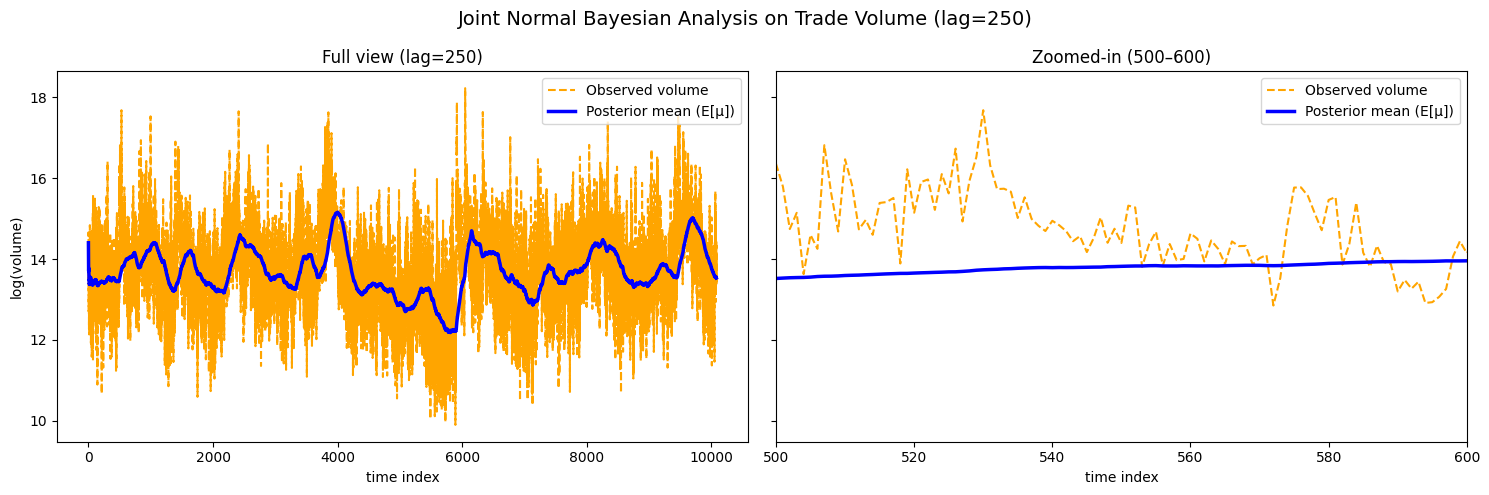

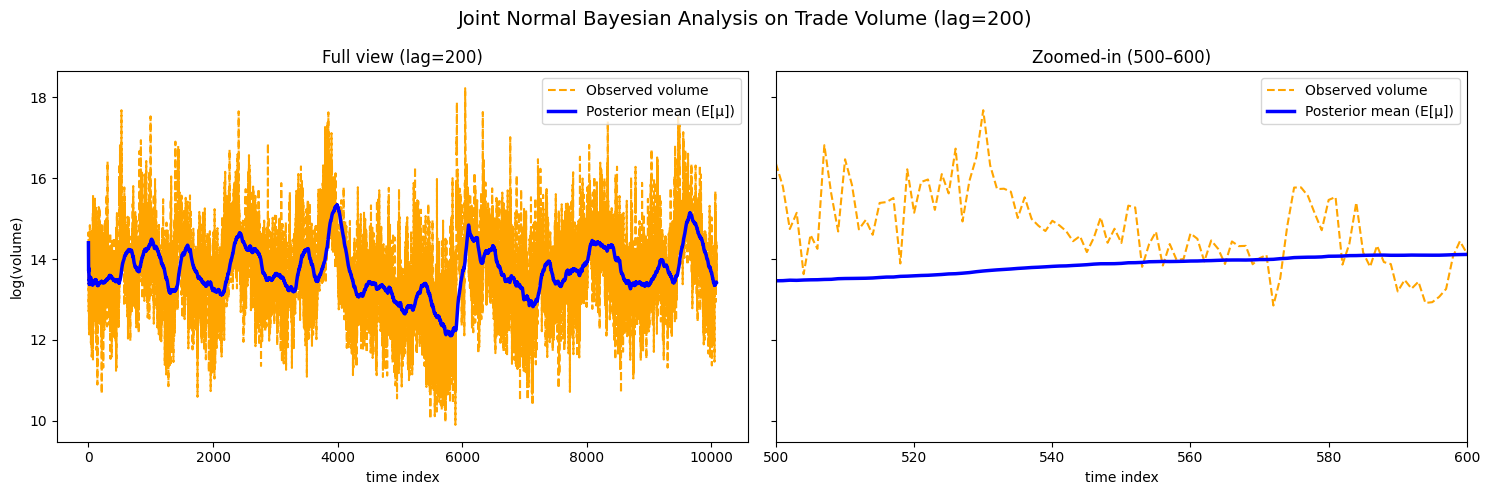

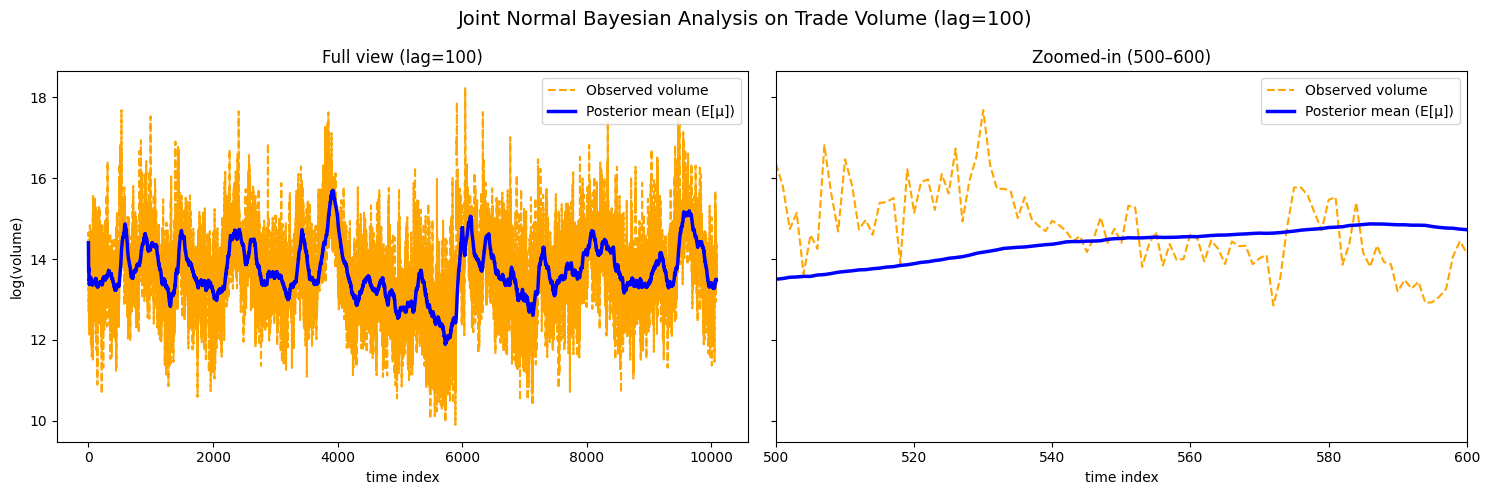

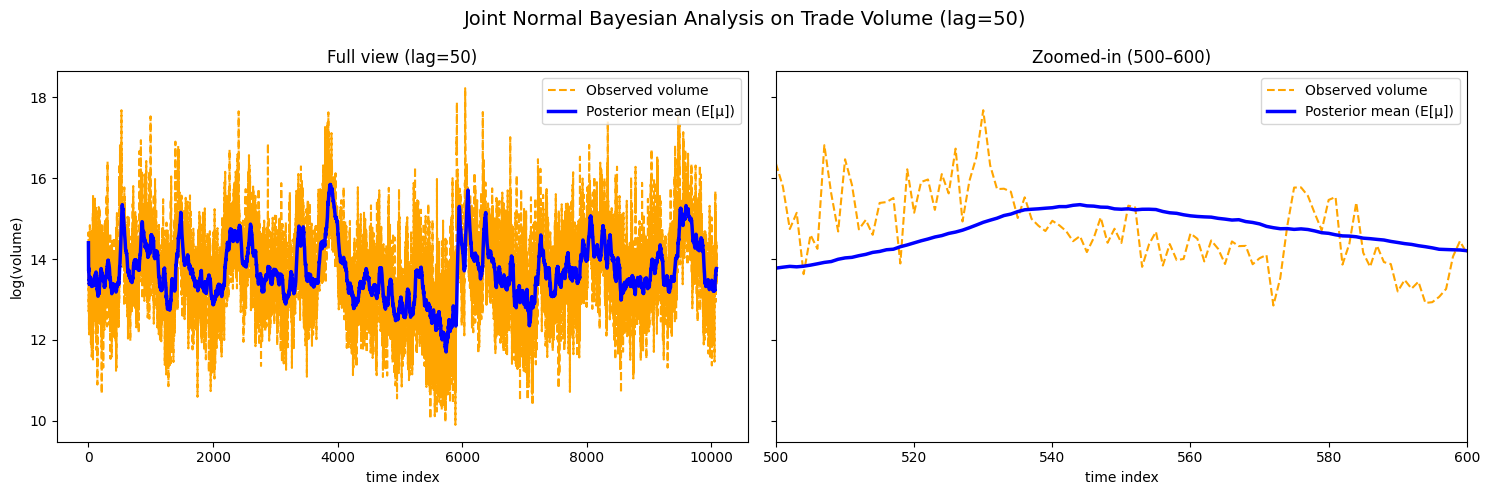

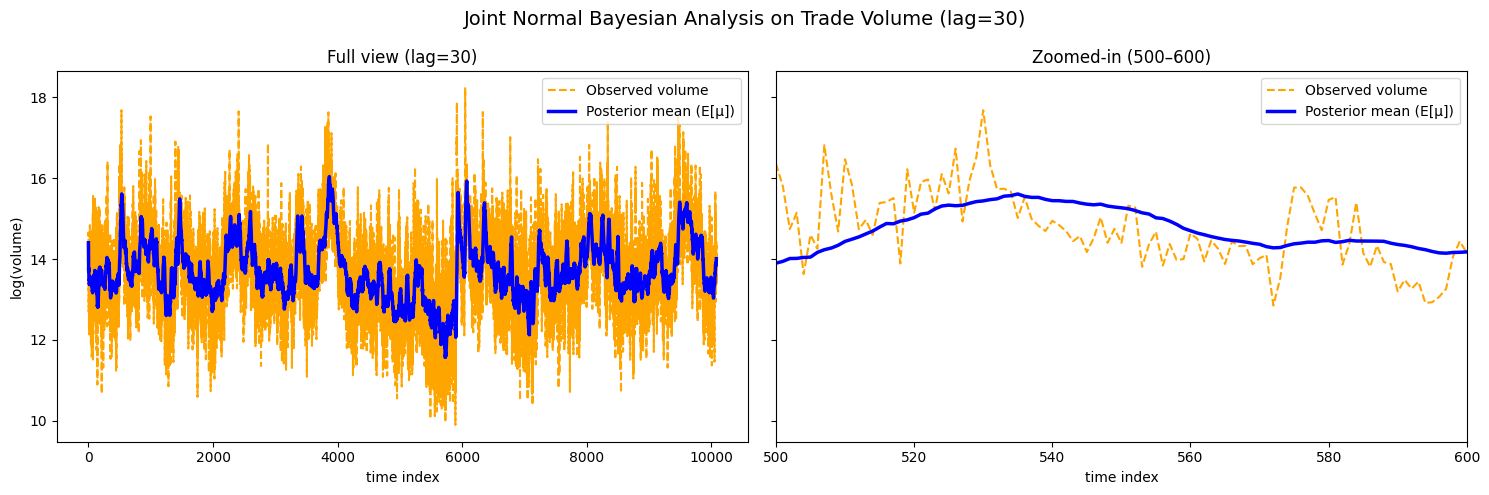

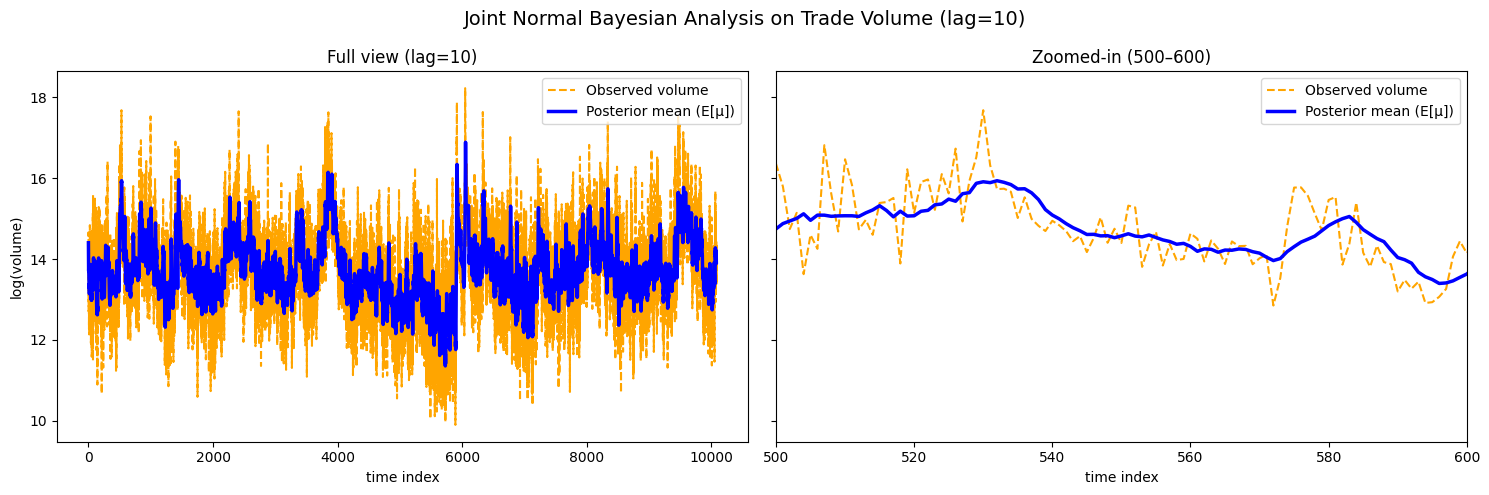

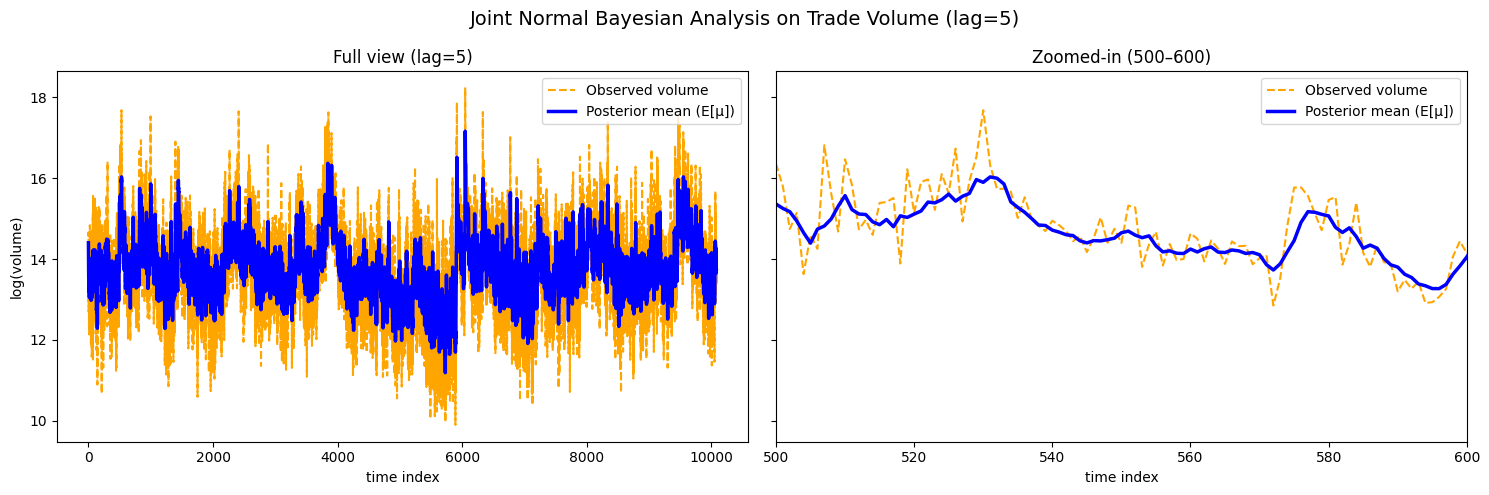

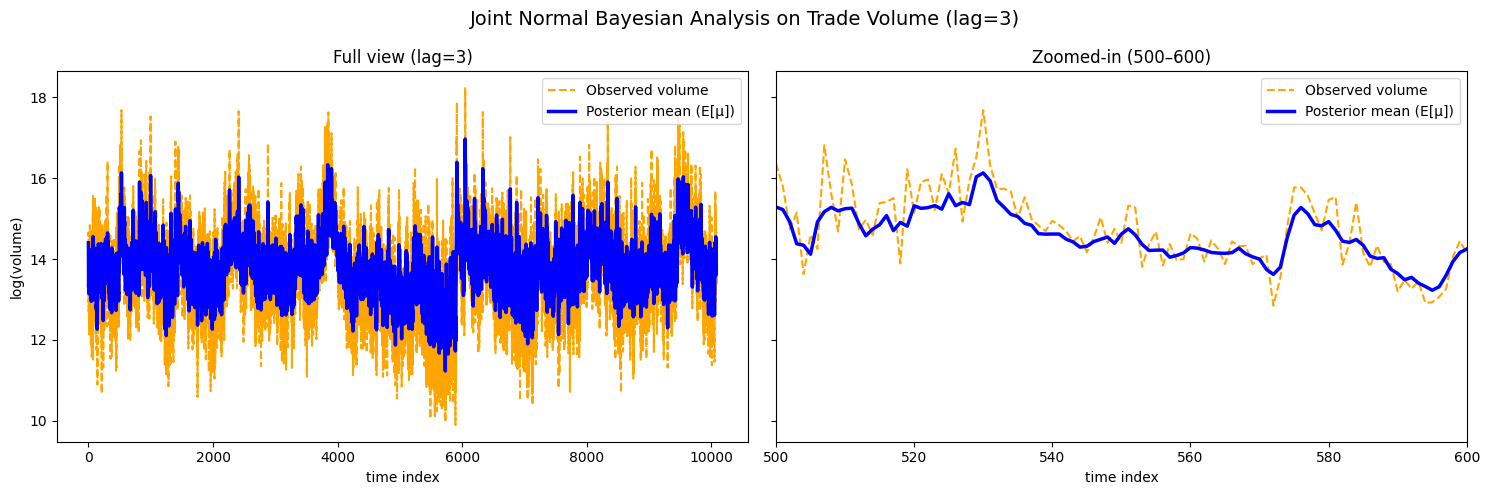

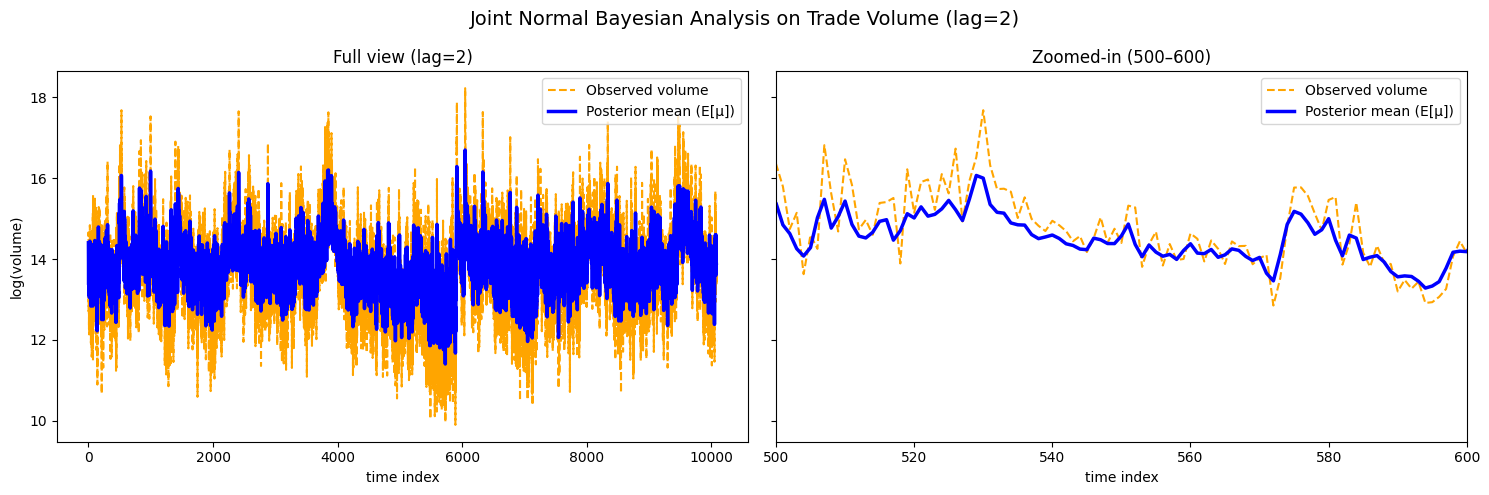

In [5]:
def expected_mu(model, lag, zoom_start=0, zoom_end=200, log_scale=True):
    df = model.df
    mu_values = model.params["mu"][1:]
    sigma2_values = model.params["sigma2"][1:]
    k_values = model.params["k"][1:]
    r_values = model.params["r"][1:]

    
    observed = np.log(df["cost"].values) if log_scale else df["cost"].values

    if not log_scale:
        mu_values = np.exp(mu_values)
        if lower is not None:
            lower = np.exp(lower)
            upper = np.exp(upper)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    x = np.arange(len(observed))

    # --- Left: Full view ---
    axs[0].plot(observed, color="orange", linestyle="--", label="Observed volume")
    axs[0].plot(mu_values, color="blue", linewidth=2.5, label="Posterior mean (E[μ])")
    axs[0].set_title(f"Full view (lag={lag})")
    axs[0].set_xlabel("time index")
    axs[0].set_ylabel("log(volume)" if log_scale else "trade volume")
    axs[0].legend()

    # --- Right: Zoomed-in view ---
    axs[1].plot(observed, color="orange", linestyle="--", label="Observed volume")
    axs[1].plot(mu_values, color="blue", linewidth=2.5, label="Posterior mean (E[μ])")
    axs[1].set_xlim(zoom_start, zoom_end)
    axs[1].set_title(f"Zoomed-in ({zoom_start}–{zoom_end})")
    axs[1].set_xlabel("time index")
    axs[1].legend()

    plt.suptitle(f"Joint Normal Bayesian Analysis on Trade Volume (lag={lag})", fontsize=14)
    plt.tight_layout()
    filename = f"JN_ExpMean_lag_{lag}.png"
    file_path = os.path.join("../figures/", filename)
    plt.savefig(file_path, format='png')
    plt.show()


for lag in [float("inf"), 400, 300, 250, 200, 100, 50, 30, 10, 5, 3, 2]:
    jn = Joint_Normal(mu=14, k=1, sigma2=4, r=1, lag=lag, df=df)
    jn.generate_posterior()
    # jn.generate_ppi(0.95)
    expected_mu(jn, lag, zoom_start=500, zoom_end=600, log_scale=True)

# Monte Carlo Simulation

Function to generate a ramdom sample
1. randomly generates $\lambda$ from Gamma Distribution
2. randomly generates no. of trades happening in 1min from Poisson$(\lambda)$

In [6]:
def gen_samples_joint_normal(params, n):
    samples = []
    for j in range(n):
        sample_j = []
        for i in range(1, len(params["mu"])):
            mu_n = params["mu"][i]
            k_n = params["k"][i]
            sigma2_n = params["sigma2"][i]
            r_n = params["r"][i]
            
            df = 2 * r_n
            scale = np.sqrt(max(0, sigma2_n) * (1 + 1 / k_n))
            
            
            x = scipy.stats.t.rvs(df, loc=mu_n, scale=scale)
            sample_j.append(x)

        samples.append(sample_j)

    return samples

# Posterior Predictive Check (PPC)

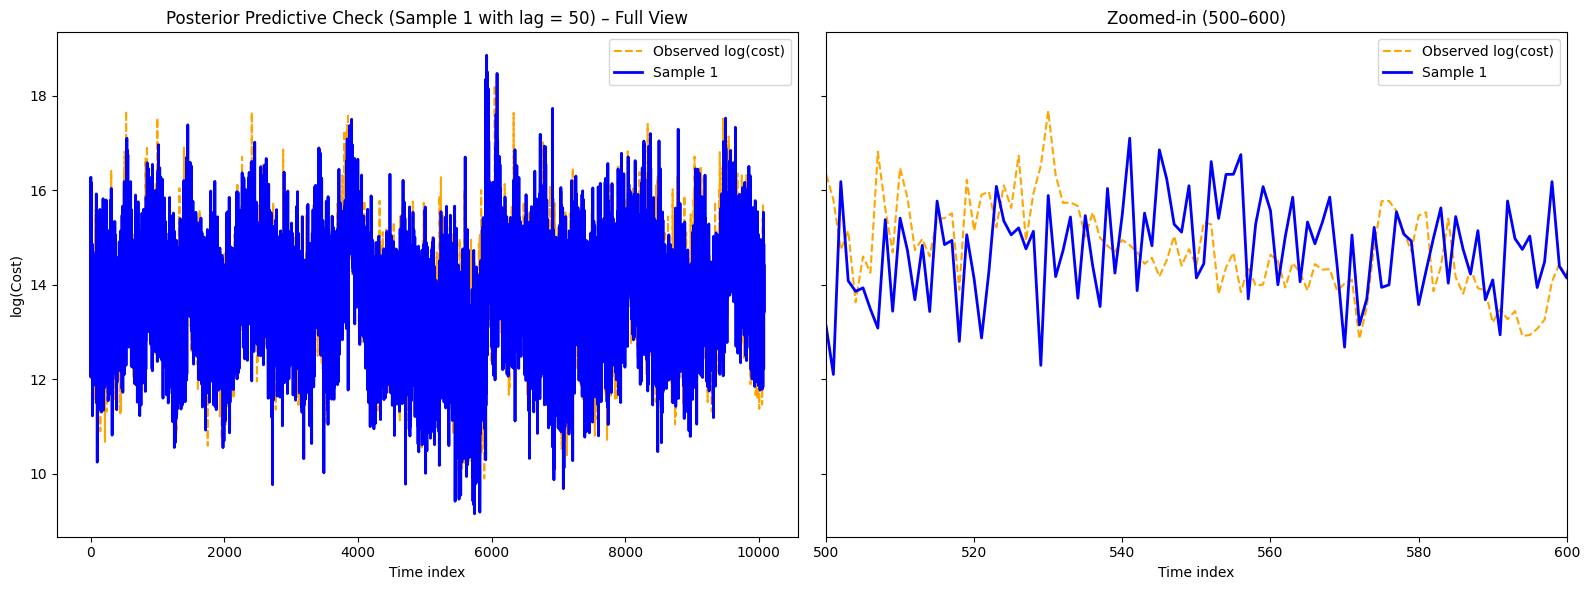

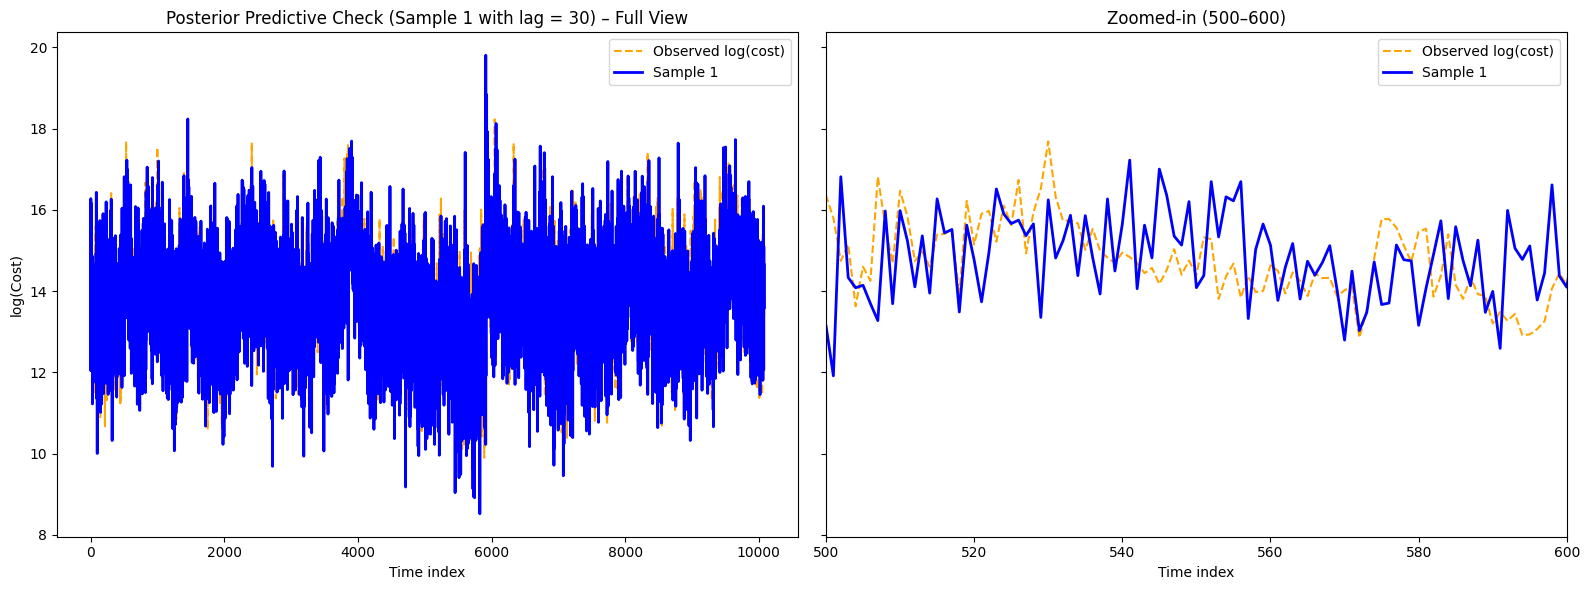

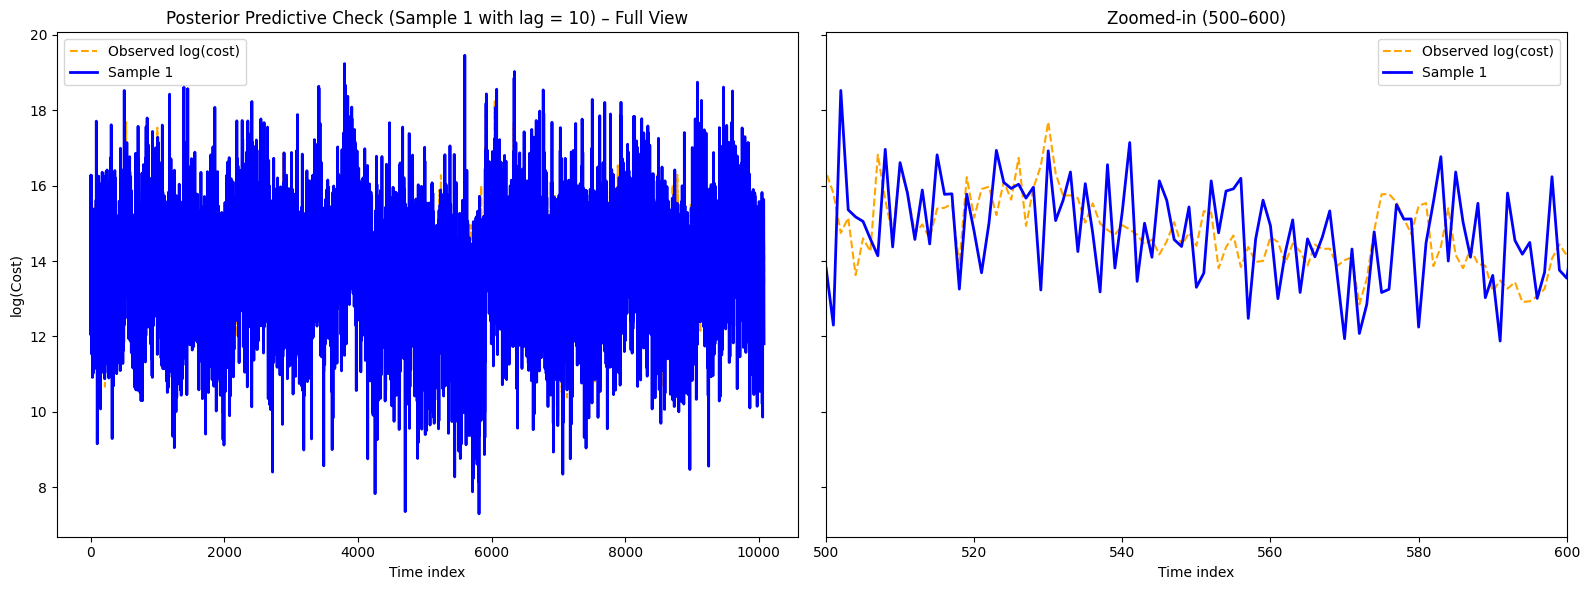

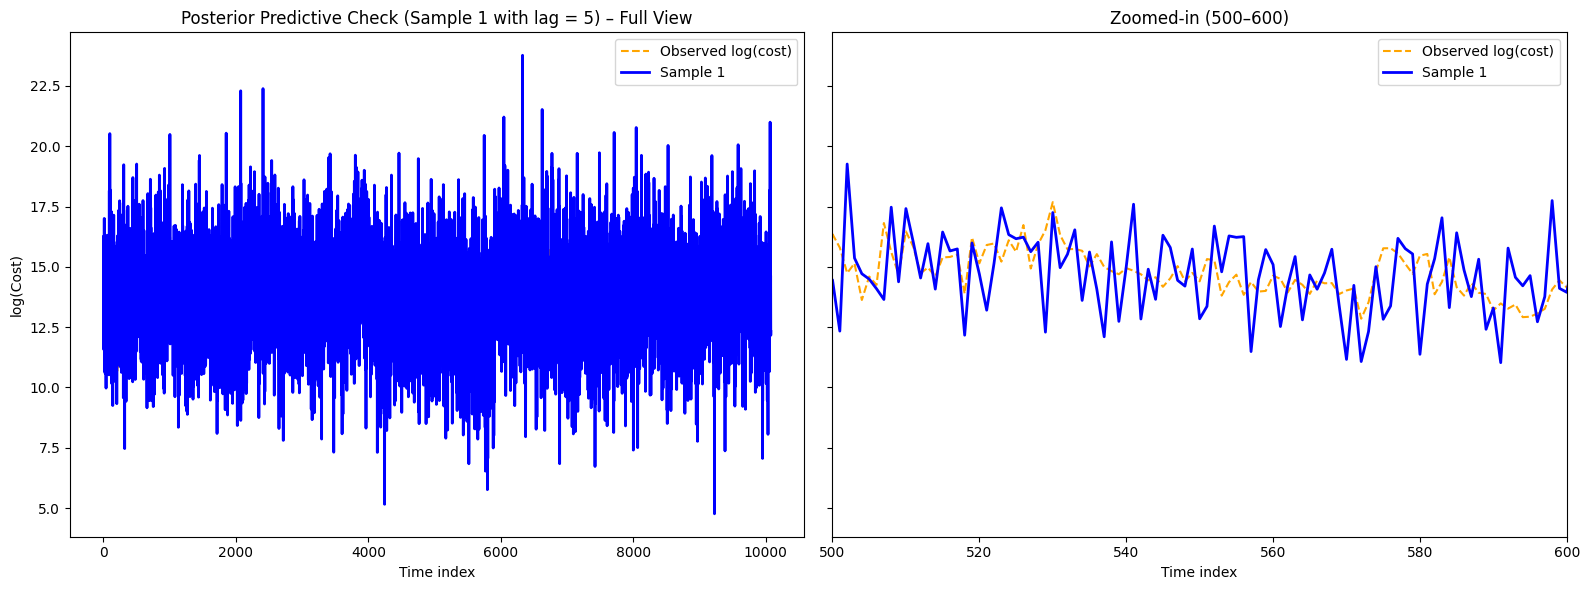

In [7]:
def plot_samples_joint_normal(samples, df, lag, zoom_start=None, zoom_end=None):
    observed = np.log(df["cost"].values)

    for i, sample in enumerate(samples, start=1):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

        # --- Main plot ---
        axes[0].plot(observed, color="orange", linestyle="--", label="Observed log(cost)")
        axes[0].plot(sample, color="blue", linewidth=2.0, label=f"Sample {i}")
        axes[0].set_title(f"Posterior Predictive Check (Sample {i} with lag = {lag}) – Full View")
        axes[0].set_xlabel("Time index")
        axes[0].set_ylabel("log(Cost)")
        axes[0].legend()

        # --- Zoomed-in plot ---
        if zoom_start is not None and zoom_end is not None:
            axes[1].plot(observed, color="orange", linestyle="--", label="Observed log(cost)")
            axes[1].plot(sample, color="blue", linewidth=2.0, label=f"Sample {i}")
            axes[1].set_xlim(zoom_start, zoom_end)
            axes[1].set_title(f"Zoomed-in ({zoom_start}–{zoom_end})")
            axes[1].set_xlabel("Time index")
            axes[1].legend()
        else:
            axes[1].axis("off")        

        plt.tight_layout()
        filename = f"JN_PPC_sample_{i}_lag_{lag}.png"
        file_path = os.path.join("../figures/", filename)
        plt.savefig(file_path, format='png')
        plt.show()

for lag in [50, 30, 10, 5]:
    jn = Joint_Normal(mu=14, k=1, sigma2=10, r=1, lag=lag, df=df)
    jn.generate_posterior()
    np.random.seed(42)
    samples = gen_samples_joint_normal(jn.params, 1)
    plot_samples_joint_normal(samples, jn.df, lag, zoom_start = 500, zoom_end = 600)

# Posterior Probability Interval (PPI)

In [8]:
def check_ppi_validity(model, alpha):
    df = model.df.sort_values(by="timestamp").reset_index(drop=True)
    y = np.log(df["cost"].to_numpy())

    lower = model.ppi[alpha]["lower_bound"]
    upper = model.ppi[alpha]["upper_bound"]

    n_valid = len(lower)
    y = y[-n_valid:]

    cnt_outside = np.sum((y < np.array(lower)) | (y > np.array(upper)))
    return int(cnt_outside), 100 * cnt_outside / n_valid


table = []
for lag in [float("inf"), 400, 300, 250, 200, 150, 100, 50, 10]:
    jn = Joint_Normal(mu=14, k=1, sigma2=10, r=1, lag=lag, df=df)
    jn.generate_posterior()
    jn.generate_ppi(0.95)

    count, percent = check_ppi_validity(jn, 0.95)
    table.append([lag, count, f"{percent:.2f}%"])

html_table = tabulate(table, headers=["Lag", "Count Outside", "Percentage Outside"], tablefmt="html")
display(HTML(html_table))

# Bayes Factor Calculation

We have modeled **Joint normal Bayesain Model** for $X_t$, with **unknown mean** $(\mu)$ and **unknown variance** $(\sigma^2)$:
$$
X_t \sim \mathcal{N}(\mu, \sigma^2)
$$

### Priors
We start with prior assumption that 
$$
\mu|\sigma \sim \mathcal{N}\bigg(\mu_0, \frac{\sigma^2}{k_0}\bigg), \quad
\sigma^2 \sim \text{Inverse-Gamma}\bigg(\frac{r_0}{2}, \frac{r_0}{2}\sigma_0^2\bigg)
$$
where $\mu_0,k_0,\sigma_0,r_0$ are pre-defined hyperparameters

We know that the Normal distribution serves as a conjugate prior for mean ($\mu$) of a Normal Distribution where variance was known. We also know that the Inverse Gamma Distribution serves as a conjugate prior for the case of unknown variance ($\sigma^2$) of a Normal Distribution where mean is known. 

It is this quite natural to combine both these distributions to perform a Joint Bayesian Analysis for the Normal Distribution. It helps simplify posterior calculations a lot. 

### Posterior Inference

Now, the **posterior distribution** of $(\mu, \sigma^2)$ can be computed analytically as

$$
\mu|\sigma \sim \mathcal{N}\bigg(\mu_n, \frac{\sigma^2}{k_n}\bigg), \quad
\sigma^2 \sim \text{Inverse-Gamma}\bigg(\frac{r_n}{2}, \frac{r_n}{2}\sigma_n^2\bigg)
$$
And the corresponding posterior updates are:
$$
\begin{align*}
k_n &= k_0+n\\
\mu_n &= \frac{k_0}{k_n}\mu_0 + \frac{n}{k_n}\overline x \\
r_n &= r_0 + n\\
\sigma^2_n &= \frac{1}{r_n}\bigg(r_0 \sigma_0^2 + (n-1)s^2 + \frac{k_0}{k_n}(\overline x^2 -\mu_0^2)\bigg)
\end{align*}
$$
These posterior distributions give us updated estimates for the mean and variance of the log-trade volumes.

We model the data as  
$$
X_t \sim \mathcal{N}(\mu, \sigma^2)
$$

with priors  
$$
\mu | \sigma^2 \sim \mathcal{N}\left(\mu_0, \frac{\sigma^2}{k_0}\right), \quad
\sigma^2 \sim \text{InvGamma}\left(\frac{r_0}{2}, \frac{r_0 \sigma_0^2}{2}\right)
$$

and posterior hyperparameters  
$$
\begin{aligned}
k_n &= k_0 + n \\
\mu_n &= \frac{k_0 \mu_0 + n \overline{x}}{k_0 + n} \\
r_n &= r_0 + n \\
\sigma_n^2 &= \frac{1}{r_n}\Big(r_0 \sigma_0^2 + (n-1)s^2 + \frac{k_0 n}{k_0 + n}(\overline{x} - \mu_0)^2 \Big)
\end{aligned}
$$

# Simple Hypothesis

### Bayes Factor for $H_0: \mu = 14$

The Bayes factor is defined as  
$$
BF_{01} = \frac{p(x \mid H_0)}{p(x \mid H_1)}
$$

---

#### 1. Marginal likelihood under $H_1$ (μ unknown, σ² unknown)

$$
p(x \mid H_1)
= \frac{\Gamma(r_n/2)}{\Gamma(r_0/2)} 
\sqrt{\frac{k_0}{k_n}}
\frac{(r_0 \sigma_0^2 / 2)^{r_0/2}}{(\pi)^{n/2} (r_n \sigma_n^2 / 2)^{r_n/2}}
$$

---

#### 2. Marginal likelihood under $H_0$ (μ fixed = 14, σ² unknown)

$$
p(x \mid H_0)
= \frac{\Gamma(r_0'/2)}{\Gamma(r_0/2)}
\frac{(r_0 \sigma_0^2 / 2)^{r_0/2}}{(\pi)^{n/2} (r_0' \sigma_0'^2 / 2)^{r_0'/2}}
$$

where  
$$
r_0' = r_0 + n, \quad
\sigma_0'^2 = \frac{1}{r_0'}\Big(r_0 \sigma_0^2 + \sum (x_i - 14)^2 \Big)
$$

---

#### 3. Bayes Factor expression

$$
BF_{01}
= 
\sqrt{\frac{k_n}{k_0}}
\frac{\Gamma(r_0'/2)}{\Gamma(r_n/2)}
\frac{(r_n \sigma_n^2 / 2)^{r_n/2}}{(r_0' \sigma_0'^2 / 2)^{r_0'/2}}
$$

with  
$$
\begin{aligned}
r_0' &= r_0 + n \\
\sigma_0'^2 &= \frac{1}{r_0'}\Big(r_0 \sigma_0^2 + \sum (x_i - 14)^2 \Big) \\
r_n &= r_0 + n \\
\sigma_n^2 &= \frac{1}{r_n}\Big(r_0 \sigma_0^2 + (n-1)s^2 + \frac{k_0 n}{k_0 + n}(\overline{x} - \mu_0)^2 \Big)
\end{aligned}
$$

$$
\boxed{\therefore
BF_{01}
= 
\sqrt{\frac{k_n}{k_0}}
\Bigg(\frac{\Big(r_0 \sigma_0^2 + (n-1)s^2 + \frac{k_0 n}{k_0 + n}(\overline{x} - \mu_0)^2 \Big)}{\Big(r_0 \sigma_0^2 + \sum (x_i - 14)^2 \Big)}\Bigg)^{r_n/2}
}
$$
---

#### Interpretation

- $BF_{01} > 1$: evidence in favor of $H_0$ (μ = 14)  
- $BF_{01} < 1$: evidence in favor of $H_1$ (μ ≠ 14)


In [7]:
class SimpleBayesFactor:
    def __init__(self, mu, k, sigma2, r, lag, df: pd.DataFrame):
        if min(sigma2, k ,r) <= 0:
            raise ValueError("sigma2, k, r must be > 0")
        if lag <=0:
            raise ValueError("lag must be a Natural number")
            
        self.lag = (lag)
        self.df = df
        
        self.params = {"mu":[mu], "k": [k], "sigma2":[sigma2], "r": [r]}
        self.bf01 = []

    def generate_posterior(self):
        df = self.df
        df = df.sort_values(by="timestamp").reset_index(drop=True)
        array = np.log(df["cost"].tolist())

        for i in range(len(array)):
            n = 0
            # sum_volume =0
            # sum2_volume =0
            
            window = array[max(0, i - self.lag):i]
            
            if len(window) < 2:
                continue
                
            n = len(window)

            # sample mean and sample variance calculation
            ybar = np.mean(window)
            s2 = np.var(window, ddof=1)

            # prior parameters
            mu0, k0, sigma20, r0 = self.params["mu"][0], self.params["k"][0], self.params["sigma2"][0], self.params["r"][0]

            # posterior updates
            kn = k0 + n
            rn = r0 + n

            mun = (k0 * mu0 + n * ybar) / kn
            sigma2n = (r0 * sigma20  + (n-1) * s2 + k0 * n * ((ybar - mu0)**2) / kn ) / rn

            numerator = r0*sigma20 + (n-1)*s2 + (k0 * n * ((ybar - mu0)**2))/kn
            denominator = r0*sigma20 + np.pow((np.array(window) -14),2).sum()
            
            bf = np.sqrt(kn/k0)*np.pow(numerator/denominator, rn/2)
            
            self.params["mu"].append(mun)
            self.params["k"].append(kn)
            self.params["sigma2"].append(sigma2n)
            self.params["r"].append(rn)
            self.bf01.append(bf)

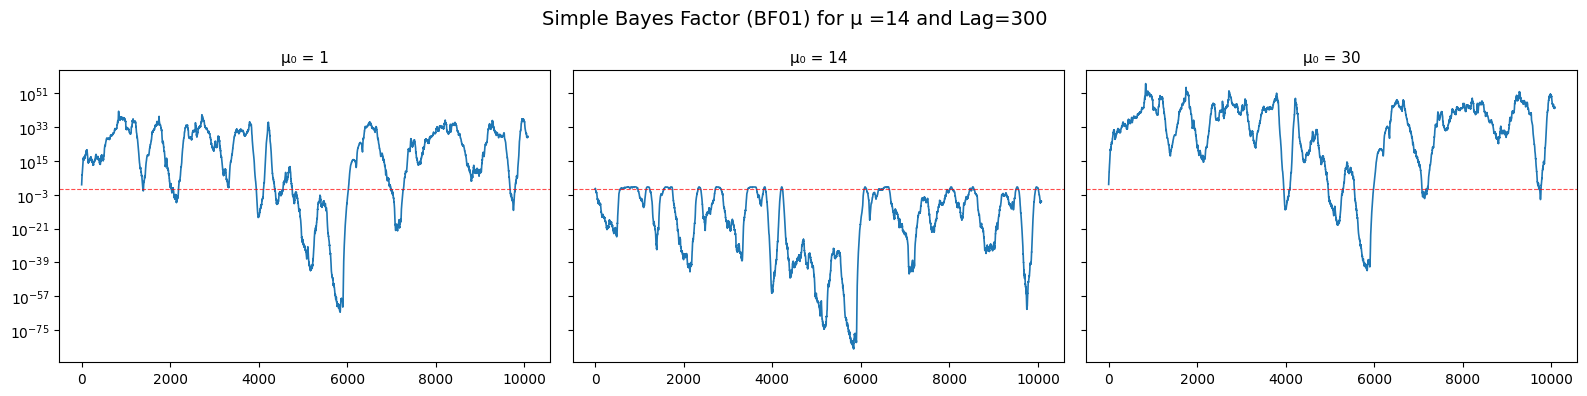

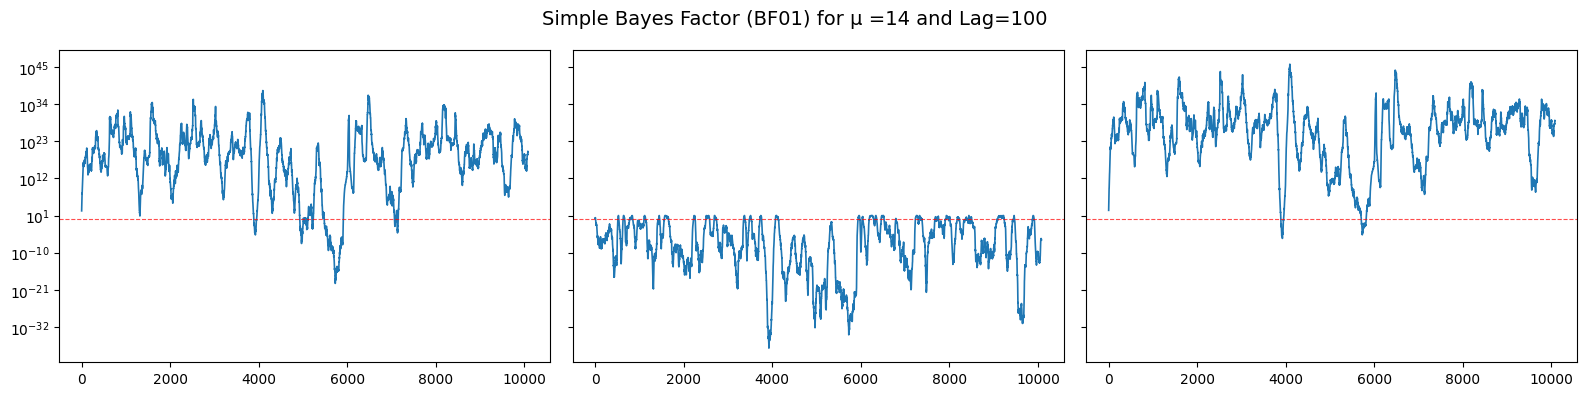

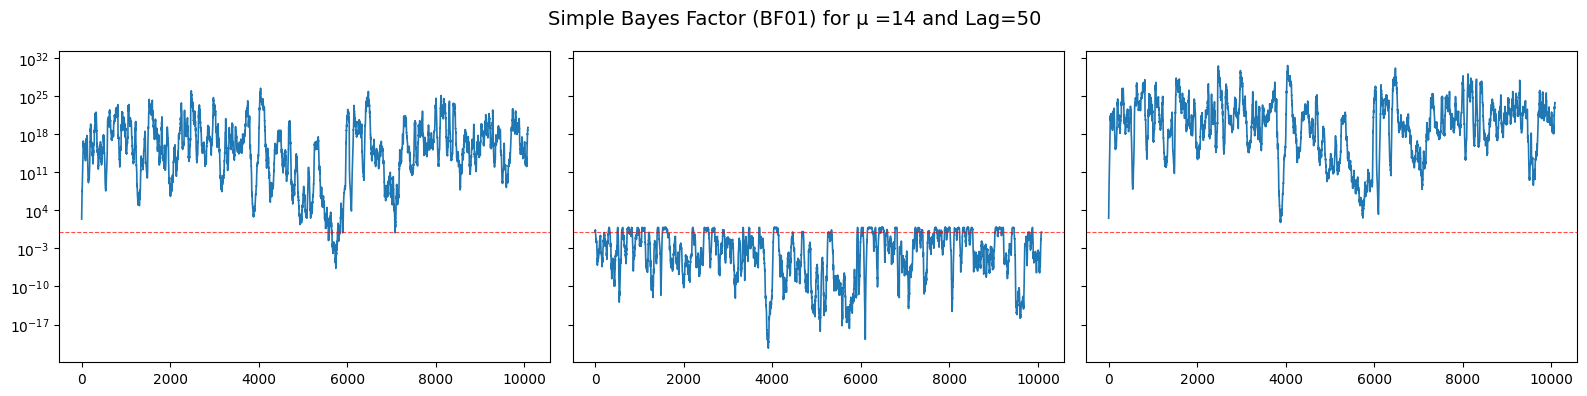

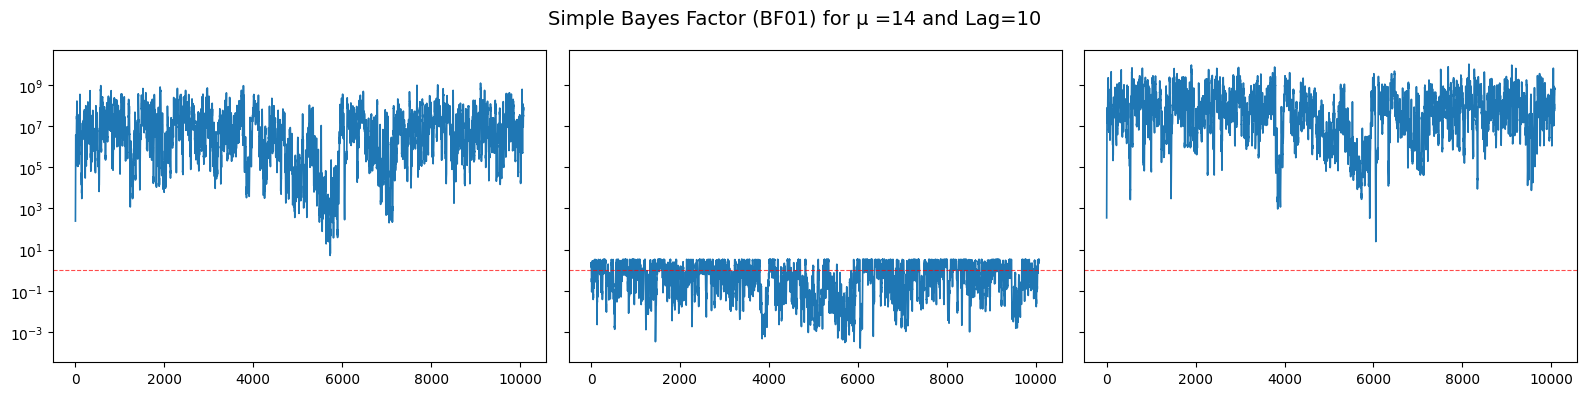

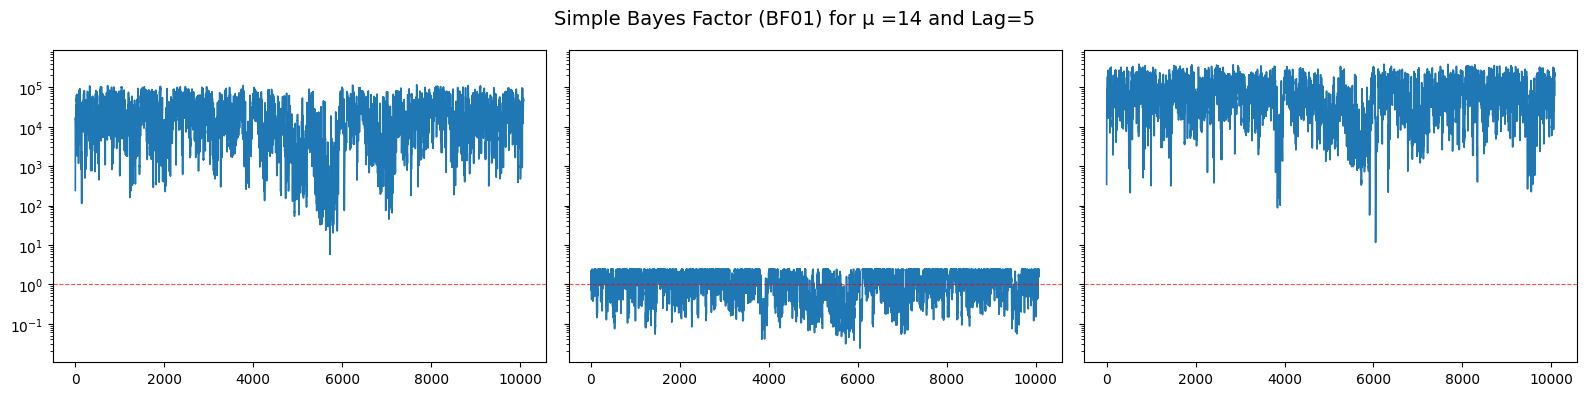

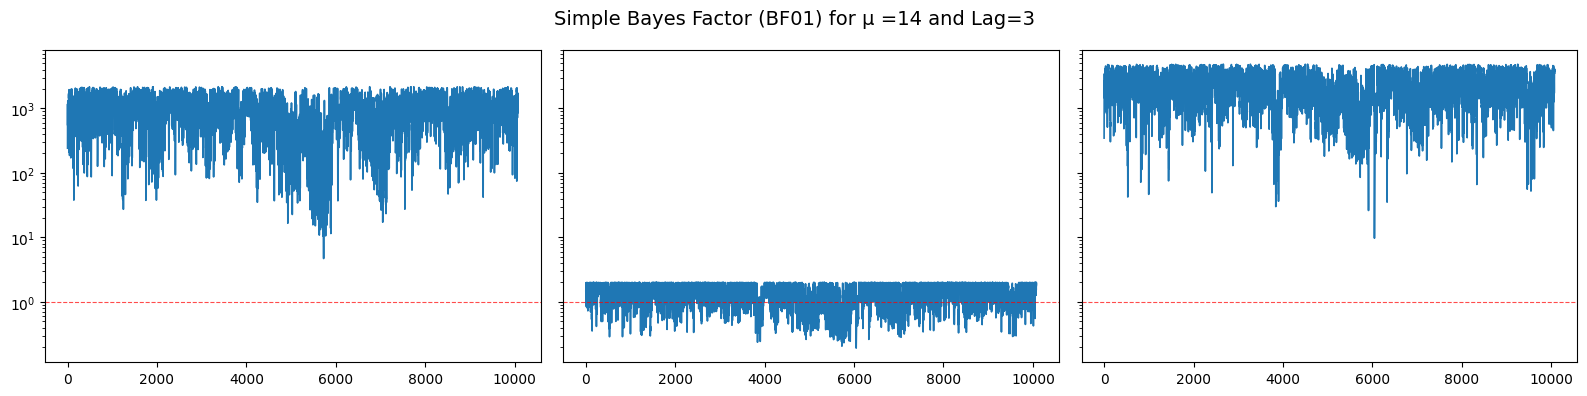

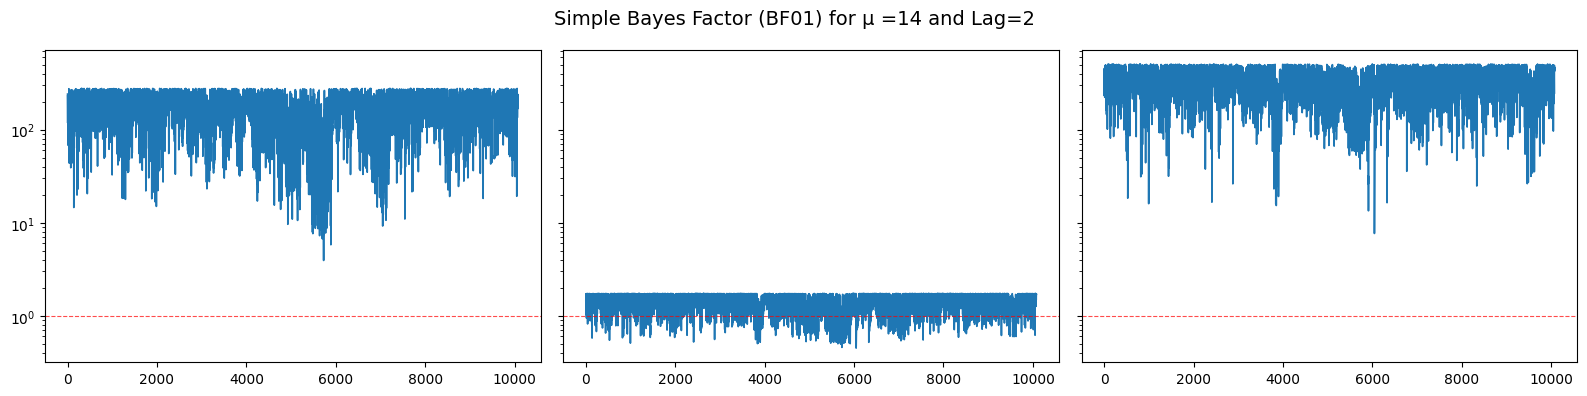

In [8]:
mu0_values = [1, 14, 30]
lags = [300, 100, 50, 10, 5, 3, 2]


for i, lag in enumerate(lags):
    fig, axs = plt.subplots(1, len(mu0_values), figsize=(16, 4), sharex=True, sharey=True)
    for j, mu0 in enumerate(mu0_values):
        ax = axs[ j]

        bf = SimpleBayesFactor(mu=mu0, k=1, sigma2=4, r=1, lag=lag, df=df)
        bf.generate_posterior()

        ax.plot(bf.bf01, linewidth=1.2)
        ax.axhline(1, color="red", linestyle="--", linewidth=0.8, alpha=0.7)
        if i == 0:
            ax.set_title(f"μ₀ = {mu0}", fontsize=11)
        # if j == 0:
            # ax.set_ylabel(f"Lag = {lag}", fontsize=10, rotation=0, labelpad=40)
        # ax.grid(alpha=0.3)
        ax.set_yscale("log")
    plt.suptitle(f"Simple Bayes Factor (BF01) for μ =14 and Lag={lag}", fontsize=14)
    plt.tight_layout()
    filename = f"Bayes_Factor_SLag_{lag}.png"
    file_path = os.path.join("../figures/", filename)
    plt.savefig(file_path, format='png')
    plt.show()

# Composite Hypothesis

Our goal is to compute the Bayes Factor ($BF_{01}$) for the hypotheses:
*   $H_0: \mu \in (a, b)$
*   $H_1: \mu \notin (a, b)$

The model is the joint Normal-Inverse-Gamma distribution, and the Bayes Factor is defined as the ratio of the posterior odds to the prior odds:
$$
BF_{01} = \frac{P(H_0|D) / (1-P(H_0|D))}{P(H_0) / (1-P(H_0))}
$$

Lets first try to find the marginal probability distributions for $\mu$ both before and after observing the data D.

### Derivation of the Marginal Prior Distribution of $\mu$

The core task is to find the marginal probability density function (PDF) of $\mu$, denoted $p(\mu)$, by integrating the joint prior PDF, $p(\mu, \sigma^2)$, over the parameter $\sigma^2$.

**The Joint Prior PDF:**
The joint prior is given by $p(\mu, \sigma^2) = p(\mu|\sigma^2)p(\sigma^2)$.
$$
p(\mu, \sigma^2) = \underbrace{\bigg[ \sqrt{\frac{k_0}{2\pi\sigma^2}} \exp\bigg(-\frac{k_0(\mu-\mu_0)^2}{2\sigma^2}\bigg) \bigg]}_{\text{PDF of } \mathcal{N}(\mu_0, \sigma^2/k_0)} \times \underbrace{\bigg[ \frac{(\frac{r_0\sigma_0^2}{2})^{\frac{r_0}{2}}}{\Gamma(\frac{r_0}{2})} (\sigma^2)^{-(\frac{r_0}{2}+1)} \exp\bigg(-\frac{r_0\sigma_0^2}{2\sigma^2}\bigg) \bigg]}_{\text{PDF of Inv-Gamma}(r_0/2, r_0\sigma_0^2/2)}
$$

**Marginalization via Integration:**
To find $p(\mu)$, we integrate with respect to $\sigma^2$:
$$
p(\mu) = \int_0^\infty p(\mu, \sigma^2) d\sigma^2
$$
Let's group the terms that are constant with respect to $\sigma^2$:
$$
p(\mu) = \sqrt{\frac{k_0}{2\pi}} \frac{(\frac{r_0\sigma_0^2}{2})^{\frac{r_0}{2}}}{\Gamma(\frac{r_0}{2})} \int_0^\infty (\sigma^2)^{-\frac{1}{2}} (\sigma^2)^{-(\frac{r_0}{2}+1)} \exp\bigg(-\frac{k_0(\mu-\mu_0)^2}{2\sigma^2} - \frac{r_0\sigma_0^2}{2\sigma^2}\bigg) d\sigma^2
$$
Combine the exponents of $\sigma^2$ and the terms within the exponential:
$$
p(\mu) = C \int_0^\infty (\sigma^2)^{-(\frac{r_0+1}{2}+1)} \exp\bigg(-\frac{1}{2\sigma^2}[r_0\sigma_0^2 + k_0(\mu-\mu_0)^2]\bigg) d\sigma^2
$$
where $C$ represents the collection of constants.

**Evaluating the Integral:**
The integrand is the kernel of an Inverse-Gamma PDF. The PDF for a random variable $X \sim \text{Inverse-Gamma}(\alpha, \beta)$ is $p(x) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{-(\alpha+1)}e^{-\beta/x}$. The integral of this PDF over its support is 1, which implies $\int_0^\infty x^{-(\alpha+1)}e^{-\beta/x} dx = \frac{\Gamma(\alpha)}{\beta^\alpha}$.

In our integral, we can identify:
*   $\alpha = \frac{r_0+1}{2}$
*   $\beta = \frac{1}{2}[r_0\sigma_0^2 + k_0(\mu-\mu_0)^2]$

Therefore, the integral evaluates to:
$$
\int_0^\infty \dots d\sigma^2 = \frac{\Gamma(\frac{r_0+1}{2})}{\bigg( \frac{1}{2}[r_0\sigma_0^2 + k_0(\mu-\mu_0)^2] \bigg)^{\frac{r_0+1}{2}}}
$$

**Final Form of the Marginal Prior PDF:**
Substituting this result back into the expression for $p(\mu)$ and simplifying:
$$
p(\mu) = \sqrt{\frac{k_0}{2\pi}} \frac{(\frac{r_0\sigma_0^2}{2})^{\frac{r_0}{2}}}{\Gamma(\frac{r_0}{2})} \frac{\Gamma(\frac{r_0+1}{2})}{ (\frac{1}{2})^{\frac{r_0+1}{2}} (r_0\sigma_0^2 + k_0(\mu-\mu_0)^2)^{\frac{r_0+1}{2}}}
$$
After significant algebraic simplification and rearrangement, this becomes:
$$
p(\mu) = \frac{\Gamma(\frac{r_0+1}{2})}{\Gamma(\frac{r_0}{2})\sqrt{\pi r_0 (\frac{\sigma_0^2}{k_0})}} \bigg( 1 + \frac{(\mu-\mu_0)^2}{r_0 (\frac{\sigma_0^2}{k_0})} \bigg)^{-\frac{r_0+1}{2}}
$$

**Identification as a Student's t-Distribution:**
The general PDF for a non-standardized Student's t-distribution with parameters $\nu$ (degrees of freedom), $\mu_{loc}$ (location), and $\sigma_{scale}$ (scale) is:
$$
p(x) = \frac{\Gamma(\frac{\nu+1}{2})}{\Gamma(\frac{\nu}{2})\sqrt{\pi \nu \sigma_{scale}^2}} \bigg( 1 + \frac{(x-\mu_{loc})^2}{\nu \sigma_{scale}^2} \bigg)^{-\frac{\nu+1}{2}}
$$
By direct comparison, we can see that our derived $p(\mu)$ is the PDF of a Student's t-distribution with the following parameters:
*   Degrees of freedom: $\nu = r_0$
*   Location: $\mu_{loc} = \mu_0$
*   Scale: $\sigma_{scale} = \sqrt{\frac{\sigma_0^2}{k_0}}$

### Derivation of the Marginal Posterior Distribution of $\mu$
The joint posterior distribution is given by the product of the conditional posterior for $\mu$ and the marginal posterior for $\sigma^2$:
$$
p(\mu, \sigma^2|D) = p(\mu|\sigma^2, D) \cdot p(\sigma^2|D)
$$
The specific forms of these distributions are:

1.  **Conditional Posterior of $\mu$:** A Normal distribution with updated parameters.
    $$
    p(\mu|\sigma^2, D) = \mathcal{N}\bigg(\mu_n, \frac{\sigma^2}{k_n}\bigg) = \sqrt{\frac{k_n}{2\pi\sigma^2}} \exp\bigg(-\frac{k_n(\mu-\mu_n)^2}{2\sigma^2}\bigg)
    $$

2.  **Marginal Posterior of $\sigma^2$:** An Inverse-Gamma distribution with updated parameters.
    $$
    p(\sigma^2|D) = \text{Inverse-Gamma}\bigg(\frac{r_n}{2}, \frac{r_n\sigma_n^2}{2}\bigg) = \frac{(\frac{r_n\sigma_n^2}{2})^{\frac{r_n}{2}}}{\Gamma(\frac{r_n}{2})} (\sigma^2)^{-(\frac{r_n}{2}+1)} \exp\bigg(-\frac{r_n\sigma_n^2}{2\sigma^2}\bigg)
    $$

To find the marginal PDF $p(\mu|D)$, we integrate the joint PDF $p(\mu, \sigma^2|D)$ over the entire support of $\sigma^2$, which is from $0$ to $\infty$.

$$
p(\mu|D) = \int_0^\infty p(\mu, \sigma^2|D) d\sigma^2
$$

Substitute the full expressions for the PDFs into the integral:

$$
p(\mu|D) = \int_0^\infty \bigg[ \sqrt{\frac{k_n}{2\pi\sigma^2}} \exp\bigg(-\frac{k_n(\mu-\mu_n)^2}{2\sigma^2}\bigg) \bigg] \bigg[ \frac{(\frac{r_n\sigma_n^2}{2})^{\frac{r_n}{2}}}{\Gamma(\frac{r_n}{2})} (\sigma^2)^{-(\frac{r_n}{2}+1)} \exp\bigg(-\frac{r_n\sigma_n^2}{2\sigma^2}\bigg) \bigg] d\sigma^2
$$

---

**Collect Constants:**
$$
p(\mu|D) = \sqrt{\frac{k_n}{2\pi}} \frac{(\frac{r_n\sigma_n^2}{2})^{\frac{r_n}{2}}}{\Gamma(\frac{r_n}{2})} \int_0^\infty \dots d\sigma^2
$$

**Combine Terms in $\sigma^2$:**
Inside the integral, we combine the powers of $\sigma^2$ and the arguments of the exponential function.
*   **Powers of $\sigma^2$:** $(\sigma^2)^{-1/2} \cdot (\sigma^2)^{-(r_n/2 + 1)} = (\sigma^2)^{-(r_n/2 + 1/2 + 1)} = (\sigma^2)^{-(\frac{r_n+1}{2}+1)}$
*   **Exponential Terms:** $\exp\bigg(-\frac{k_n(\mu-\mu_n)^2}{2\sigma^2} - \frac{r_n\sigma_n^2}{2\sigma^2}\bigg) = \exp\bigg(-\frac{1}{2\sigma^2}[k_n(\mu-\mu_n)^2 + r_n\sigma_n^2]\bigg)$

The integral now takes the form:
$$
p(\mu|D) = C \cdot \int_0^\infty (\sigma^2)^{-(\frac{r_n+1}{2}+1)} \exp\bigg(-\frac{1}{2\sigma^2}[r_n\sigma_n^2 + k_n(\mu-\mu_n)^2]\bigg) d\sigma^2
$$
where $C$ represents the collection of constants from step 3.1.

---

**Evaluate the Integral by Recognizing its Form**

The expression inside the integral is the kernel of an Inverse-Gamma PDF. Recall that the PDF for $X \sim \text{Inverse-Gamma}(\alpha, \beta)$ is $p(x) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{-(\alpha+1)}e^{-\beta/x}$. Since the integral of any PDF over its support is 1, we know that:
$$
\int_0^\infty x^{-(\alpha+1)}e^{-\beta/x} dx = \frac{\Gamma(\alpha)}{\beta^\alpha}
$$
By comparing our integrand to this form, we can identify:
*   Shape parameter $\alpha = \frac{r_n+1}{2}$
*   Scale parameter $\beta = \frac{1}{2}[r_n\sigma_n^2 + k_n(\mu-\mu_n)^2]$

Using this identity, the integral evaluates to:
$$
\int_0^\infty \dots d\sigma^2 = \frac{\Gamma(\frac{r_n+1}{2})}{\bigg( \frac{1}{2}[r_n\sigma_n^2 + k_n(\mu-\mu_n)^2] \bigg)^{\frac{r_n+1}{2}}}
$$

**Substitute the Result**

Now we substitute the result of the integration back into the expression for $p(\mu|D)$ and simplify.

$$
p(\mu|D) = \sqrt{\frac{k_n}{2\pi}} \frac{(\frac{r_n\sigma_n^2}{2})^{\frac{r_n}{2}}}{\Gamma(\frac{r_n}{2})} \cdot \frac{\Gamma(\frac{r_n+1}{2})}{\big(\frac{1}{2}\big)^{\frac{r_n+1}{2}} \big(r_n\sigma_n^2 + k_n(\mu-\mu_n)^2\big)^{\frac{r_n+1}{2}}}
$$
Let's simplify this term by term.
$$
p(\mu|D) = \frac{\Gamma(\frac{r_n+1}{2})}{\Gamma(\frac{r_n}{2})} \frac{\sqrt{k_n}}{\sqrt{2\pi}} \frac{(r_n\sigma_n^2/2)^{r_n/2}}{ (1/2)^{(r_n+1)/2} } \frac{1}{(r_n\sigma_n^2 + k_n(\mu-\mu_n)^2)^{\frac{r_n+1}{2}}}
$$
$$
p(\mu|D) = \frac{\Gamma(\frac{r_n+1}{2})}{\Gamma(\frac{r_n}{2})} \frac{\sqrt{k_n}}{\sqrt{\pi}} \frac{(r_n\sigma_n^2)^{r_n/2}}{ (r_n\sigma_n^2 + k_n(\mu-\mu_n)^2)^{\frac{r_n+1}{2}}}
$$
To get this into a standard form, we factor out $r_n\sigma_n^2$ from the denominator term:
$$
\big(r_n\sigma_n^2 + k_n(\mu-\mu_n)^2\big)^{\frac{r_n+1}{2}} = (r_n\sigma_n^2)^{\frac{r_n+1}{2}} \bigg(1 + \frac{k_n(\mu-\mu_n)^2}{r_n\sigma_n^2}\bigg)^{\frac{r_n+1}{2}}
$$
Substituting this back in:
$$
p(\mu|D) = \frac{\Gamma(\frac{r_n+1}{2})}{\Gamma(\frac{r_n}{2})} \frac{\sqrt{k_n}}{\sqrt{\pi}} \frac{(r_n\sigma_n^2)^{r_n/2}}{ (r_n\sigma_n^2)^{\frac{r_n+1}{2}} } \bigg(1 + \frac{k_n(\mu-\mu_n)^2}{r_n\sigma_n^2}\bigg)^{-\frac{r_n+1}{2}}
$$
The terms involving $r_n\sigma_n^2$ simplify: $\frac{(r_n\sigma_n^2)^{r_n/2}}{(r_n\sigma_n^2)^{(r_n+1)/2}} = (r_n\sigma_n^2)^{-1/2} = \frac{1}{\sqrt{r_n\sigma_n^2}}$.
$$
p(\mu|D) = \frac{\Gamma(\frac{r_n+1}{2})}{\Gamma(\frac{r_n}{2})} \frac{\sqrt{k_n}}{\sqrt{\pi}} \frac{1}{\sqrt{r_n\sigma_n^2}} \bigg(1 + \frac{(\mu-\mu_n)^2}{r_n (\sigma_n^2/k_n)}\bigg)^{-\frac{r_n+1}{2}}
$$
Finally, combine the terms under the square root:
$$
\frac{\sqrt{k_n}}{\sqrt{\pi r_n \sigma_n^2}} = \frac{1}{\sqrt{\pi r_n (\sigma_n^2/k_n)}}
$$
This gives the final form of the density:
$$
p(\mu|D) = \frac{\Gamma(\frac{r_n+1}{2})}{\Gamma(\frac{r_n}{2})\sqrt{\pi r_n (\frac{\sigma_n^2}{k_n})}} \bigg(1 + \frac{(\mu-\mu_n)^2}{r_n (\frac{\sigma_n^2}{k_n})}\bigg)^{-\frac{r_n+1}{2}}
$$

**Identification as a Student's t-Distribution**

We now compare our derived PDF with the canonical PDF of a non-standardized Student's t-distribution, which is defined by a degrees of freedom parameter $\nu$, a location parameter $\mu_{loc}$, and a scale parameter $\sigma_{scale}$:
$$
p(x) = \frac{\Gamma(\frac{\nu+1}{2})}{\Gamma(\frac{\nu}{2})\sqrt{\pi \nu \sigma_{scale}^2}} \bigg( 1 + \frac{(x-\mu_{loc})^2}{\nu \sigma_{scale}^2} \bigg)^{-\frac{\nu+1}{2}}
$$
By direct term-by-term comparison of $p(\mu|D)$ with $p(x)$, we can definitively identify the parameters:
*   **Degrees of Freedom:** $\nu = r_n$
*   **Location:** $\mu_{loc} = \mu_n$
*   **Scale:** $\sigma_{scale} = \sqrt{\frac{\sigma_n^2}{k_n}}$

Thus, the marginal posterior distribution of $\mu$ is a **Student's t-distribution** with the parameters specified above.

### Calculation of Probabilities and the Bayes Factor

Having mathematically derived the marginal distributions, we can now compute the required probabilities using their Cumulative Distribution Functions (CDFs). Let $F_{t(\nu, \mu_{loc}, \sigma_{scale})}$ denote the CDF of the specified Student's t-distribution.

**Prior Probability $P(H_0)$:**
$$
P(H_0) = P(\mu \in (a, b)) = \int_a^b p(\mu) d\mu = F_{t(r_0, \mu_0, \sqrt{\sigma_0^2/k_0})}(b) - F_{t(r_0, \mu_0, \sqrt{\sigma_0^2/k_0})}(a)
$$

**Posterior Probability $P(H_0|D)$:**
$$
P(H_0|D) = P(\mu \in (a, b)|D) = \int_a^b p(\mu|D) d\mu = F_{t(r_n, \mu_n, \sqrt{\sigma_n^2/k_n})}(b) - F_{t(r_n, \mu_n, \sqrt{\sigma_n^2/k_n})}(a)
$$

**Final Bayes Factor:**
The Bayes Factor $BF_{01}$ is assembled by substituting these probabilities into the odds ratio formula. Let $\pi_0 = P(H_0)$ and $\pi_{0|D} = P(H_0|D)$.

$$
BF_{01} = \frac{\pi_{0|D} / (1-\pi_{0|D})}{\pi_0 / (1-\pi_0)}
$$
Substituting the CDF expressions:
$$
BF_{01} = \frac{\frac{F_{post}(b) - F_{post}(a)}{1 - (F_{post}(b) - F_{post}(a))}}{\frac{F_{prior}(b) - F_{prior}(a)}{1 - (F_{prior}(b) - F_{prior}(a))}}
$$
where $F_{prior}$ and $F_{post}$ are the CDFs of the prior and posterior t-distributions derived above. This is the final, computationally tractable result.

In [17]:
class CompositeBayesFactor:
    def __init__(self, mu: float, k: float, sigma2: float, r: float, 
                 a: float, b: float, lag: int, df: pd.DataFrame):
        if min(sigma2, k, r) <= 0:
            raise ValueError("sigma2, k, r must be > 0")
        if lag <= 0:
            raise ValueError("lag must be a Natural number")
        if a >= b:
            raise ValueError("The lower bound 'a' must be less than the upper bound 'b'")
            
        self.lag = lag
        self.df = df
        self.interval = (a, b)
        self.prior_params = {"mu0": mu, "k0": k, "sigma20": sigma2, "r0": r}
        self.posterior_history = []
        self.bf01 = []

    def generate_posterior(self):
        df_sorted = self.df.sort_values(by="timestamp").reset_index(drop=True)
        log_cost_array = np.log(df_sorted["cost"].to_numpy())

        for i in range(len(log_cost_array)):
            window = log_cost_array[max(0, i - self.lag) : i]
            if len(window) < 2:
                continue
                
            n = len(window)
            ybar = np.mean(window)
            s2 = np.var(window, ddof=1) if n > 1 else 0

            mu0 = self.prior_params["mu0"]
            k0 = self.prior_params["k0"]
            sigma20 = self.prior_params["sigma20"]
            r0 = self.prior_params["r0"]

            # Standard posterior update rules
            kn = k0 + n
            rn = r0 + n
            mun = (k0 * mu0 + n * ybar) / kn
            sigma2n = (r0 * sigma20  + (n - 1) * s2 + (k0 * n * (ybar - mu0)**2) / kn ) / rn
            
            current_posterior = {"mun": mun, "kn": kn, "sigma2n": sigma2n, "rn": rn}
            self.posterior_history.append(current_posterior)

            a, b = self.interval
            
            # --- Prior Probability P(H0) ---
            prior_dof = r0
            prior_loc = mu0
            prior_scale = np.sqrt(sigma20 / k0)
            
            p_h0 = t.cdf(b, df=prior_dof, loc=prior_loc, scale=prior_scale) - t.cdf(a, df=prior_dof, loc=prior_loc, scale=prior_scale)
            log_prior_odds = np.log(p_h0) - np.log1p(-p_h0)
            
            # --- Posterior Probability P(H0|D) ---
            post_dof = rn
            post_loc = mun
            post_scale = np.sqrt(sigma2n / kn)

            p_h0_given_d = t.cdf(b, df=post_dof, loc=post_loc, scale=post_scale) - t.cdf(a, df=post_dof, loc=post_loc, scale=post_scale)

            # Calculating the Bayes Factor
            # BF01 = Posterior Odds / Prior Odds
            if p_h0_given_d == 1.0:
                # If p=1, log-odds are infinite
                log_posterior_odds = np.inf
            elif p_h0_given_d == 0.0:
                # If p=0, log-odds are negative infinite
                log_posterior_odds = -np.inf
            else:
                log_posterior_odds = np.log(p_h0_given_d) - np.log1p(-p_h0_given_d)
        
            log_bf = log_posterior_odds - log_prior_odds
            
            self.bf01.append(log_bf)

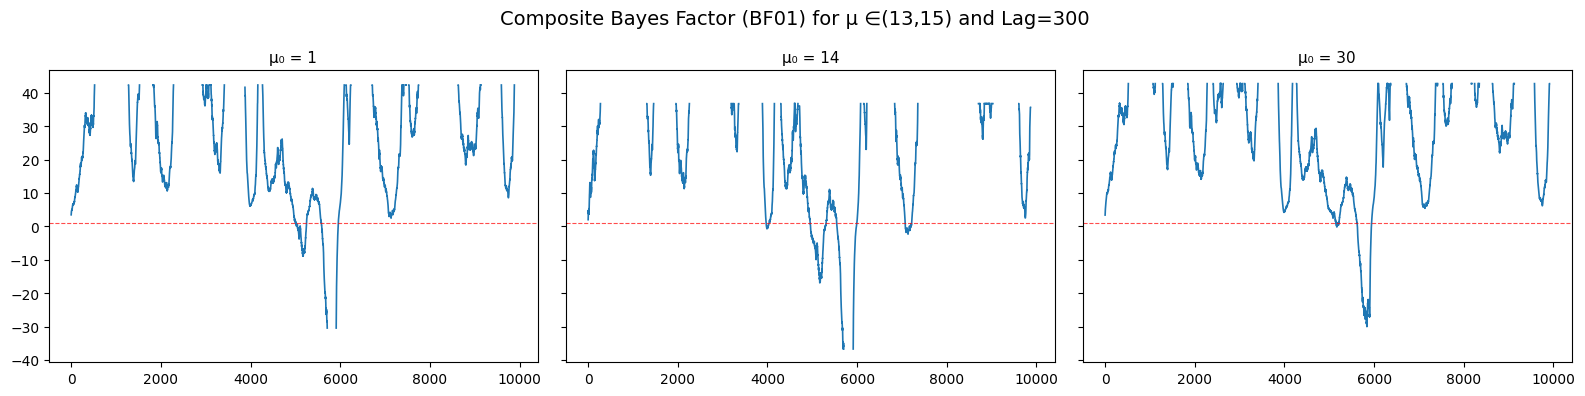

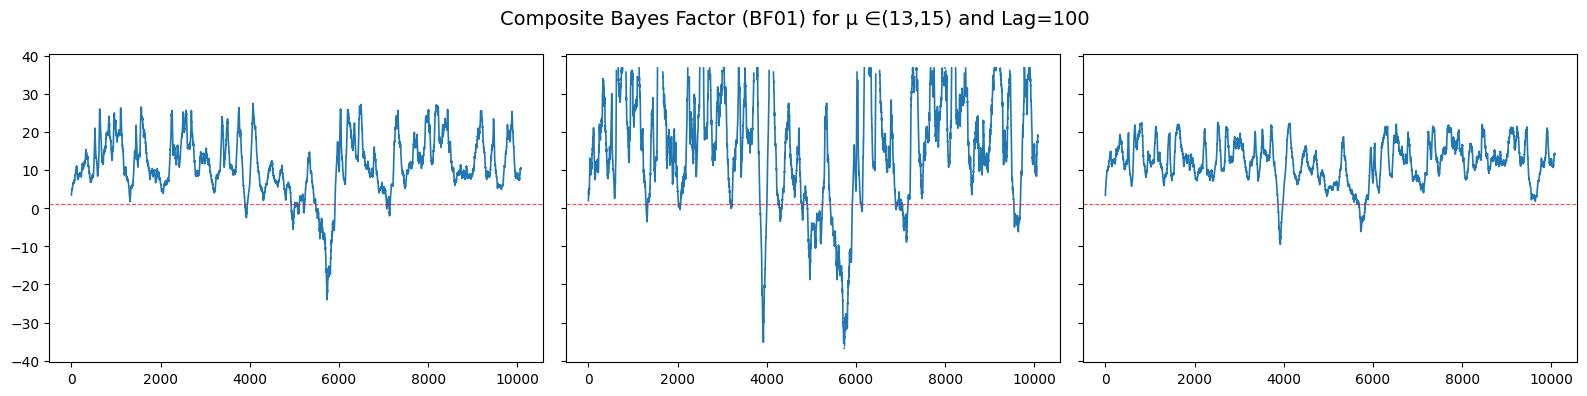

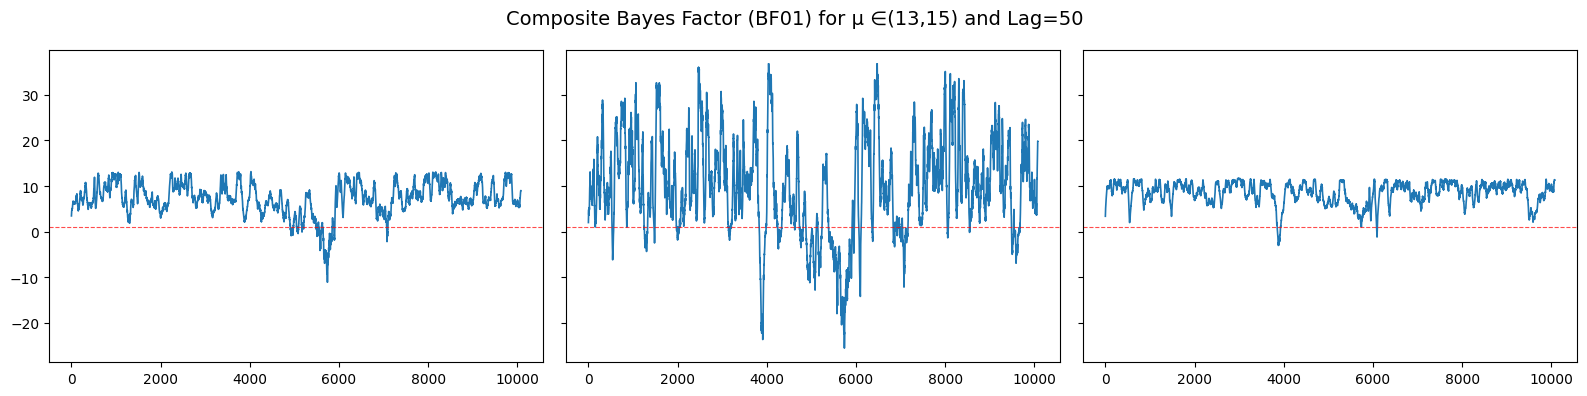

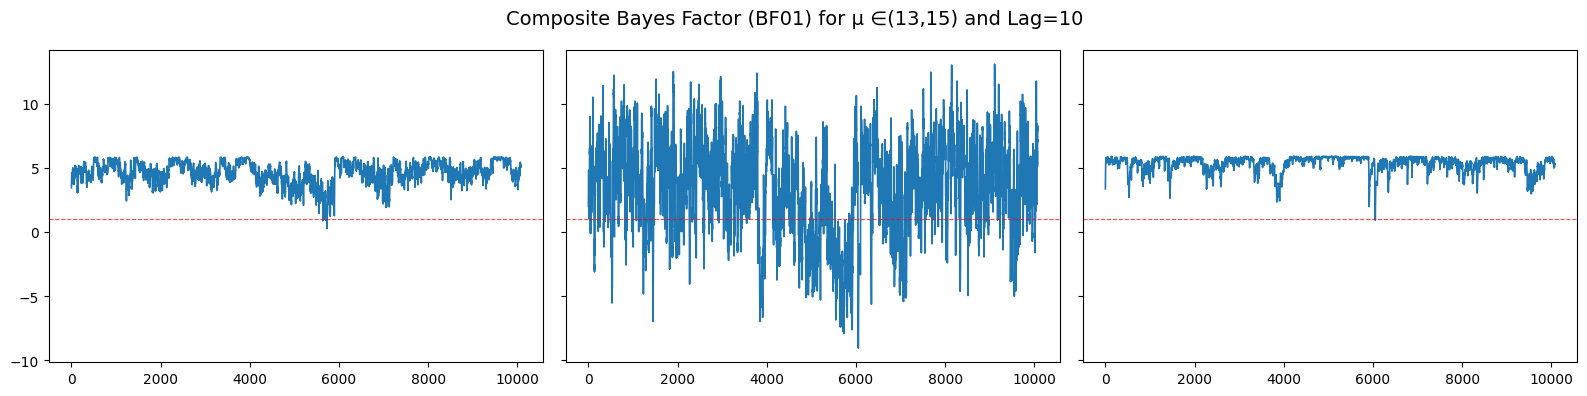

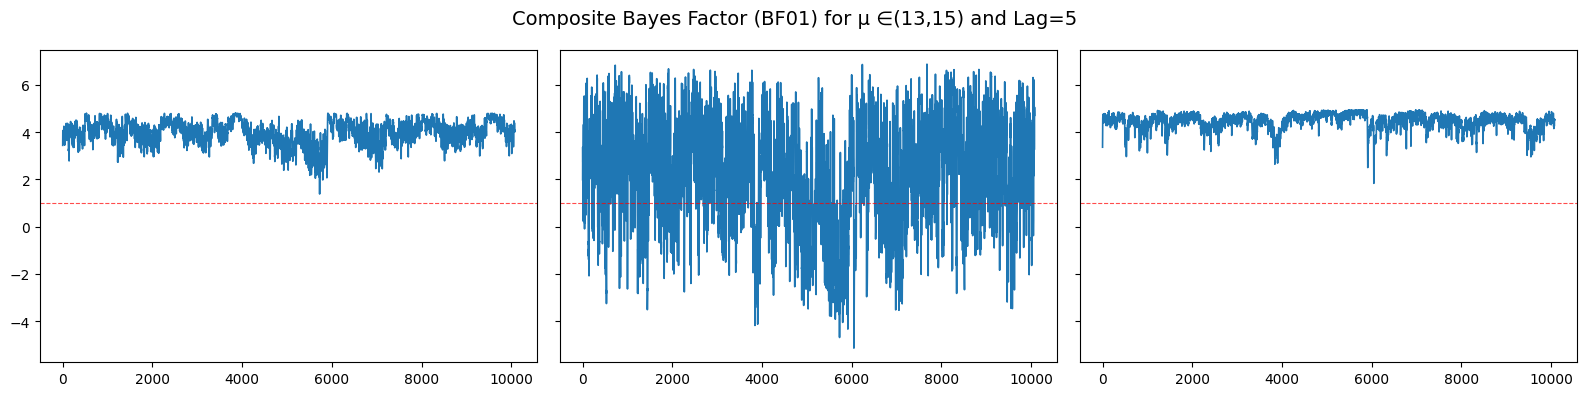

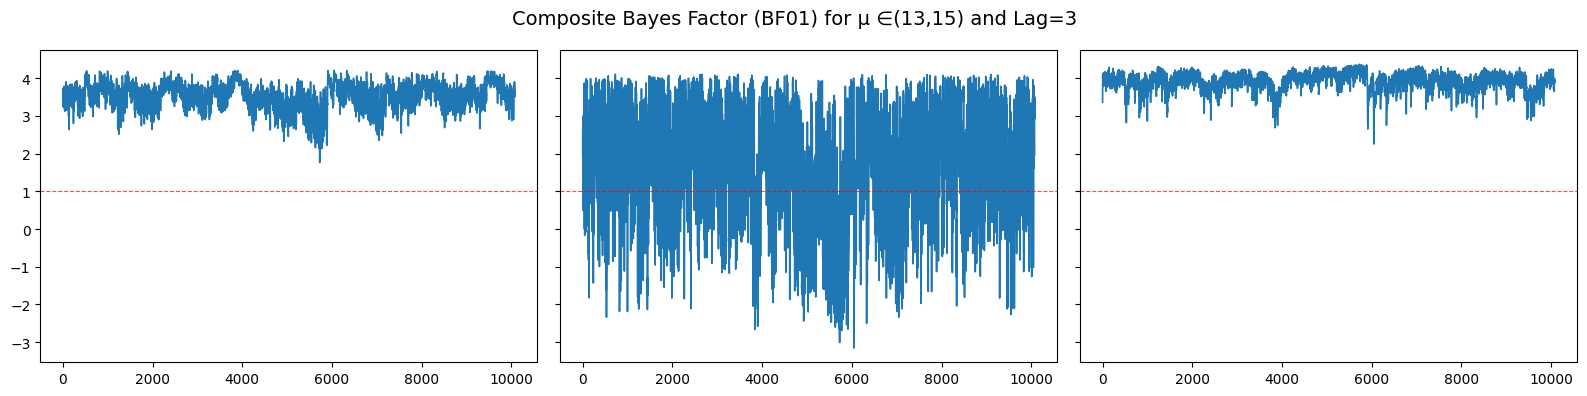

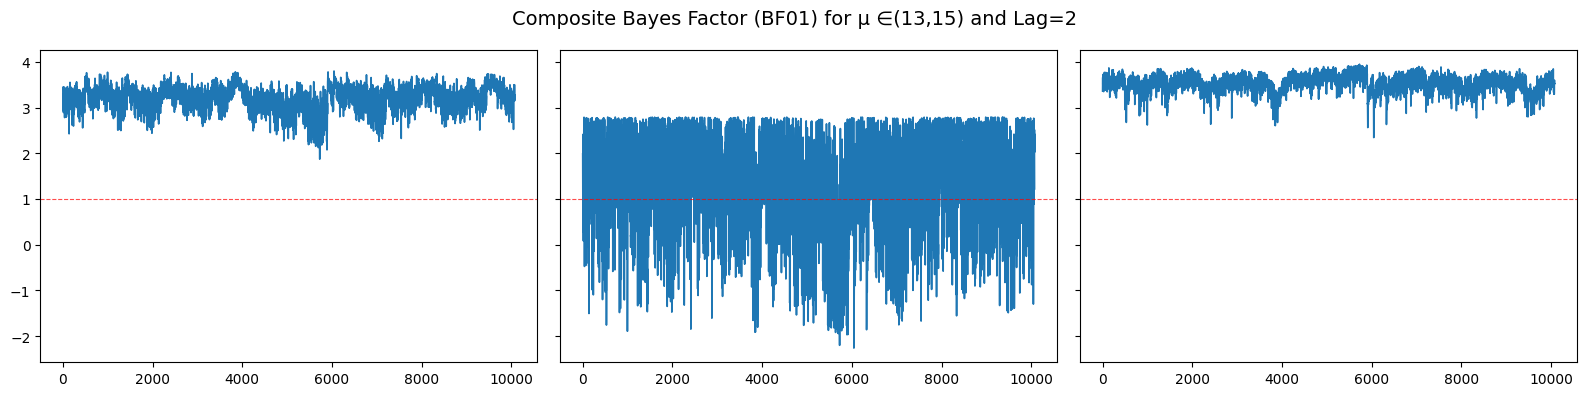

In [19]:
mu0_values = [1, 14, 30]
lags = [300, 100, 50, 10, 5, 3, 2]
a= 13
b= 15

for i, lag in enumerate(lags):
    fig, axs = plt.subplots(1, len(mu0_values), figsize=(16, 4), sharex=True, sharey=True)
    for j, mu0 in enumerate(mu0_values):
        ax = axs[j]

        bf = CompositeBayesFactor(
                mu=mu0,
                k=1.0,
                sigma2=1.0,
                r=1.0,
                a=a,
                b=b,
                lag=lag,
                df=df
            )
        bf.generate_posterior()

        ax.plot(bf.bf01, linewidth=1.2)
        ax.axhline(1, color="red", linestyle="--", linewidth=0.8, alpha=0.7)
        if i == 0:
            ax.set_title(f"μ₀ = {mu0}", fontsize=11)
        # if j == 0:
            # ax.set_ylabel(f"Lag = {lag}", fontsize=10, rotation=0, labelpad=40)
        # ax.grid(alpha=0.3)
        # ax.set_yscale("log")
    plt.suptitle(f"Composite Bayes Factor (BF01) for μ ∈({a},{b}) and Lag={lag}", fontsize=14)
    plt.tight_layout()
    filename = f"Bayes_Factor_CLag_{lag}.png"
    file_path = os.path.join("../figures/", filename)
    plt.savefig(file_path, format='png')
    plt.show()